<a href="https://colab.research.google.com/github/maheshyadav007/research/blob/main/Circle%20Exp%20Notebooks/NPK_MNIST_experiment_all_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [298]:
#!pip install torchviz

In [299]:
import numpy as np
import pandas as pd

import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib


import random
import os
import copy
import torch 
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split 
import seaborn as sns
#from torchviz import make_dot
from google.colab import files
from scipy.linalg import eigh

# %matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"
%matplotlib inline
# matplotlib.use('agg')

In [300]:
import numpy as np 
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

**Input Generation**

In [301]:
def set_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  # Python RNG
  np.random.seed(seed)
  random.seed(seed)

In [302]:
# angles = np.arange(0,2*np.pi, 0.01)

# x=np.zeros((len(angles),2))
# y=np.zeros(len(angles))

# a=1 # Number of half cycles in the top half of the circle
# b=17 # number of half cycles in the bottom half of the circle

# for idx, angle in enumerate(angles):
#     x[idx,0]=np.cos(angle)
#     x[idx,1]=np.sin(angle)
#     if angle<np.pi:
#         y[idx] = np.sin(a*angle)
#     else:
#         y[idx] = np.sin(a*np.pi+b*(angle-np.pi))   

# # plt.plot(np.concatenate((angles,angles+np.pi*2)),np.concatenate((y,y)))
# plt.plot(angles, y)
# plt.figure()
# plt.axis('equal')
# plt.scatter(x[:,0],x[:,1],c=y)

In [303]:

# delta = 10*np.pi/180
# point_x1 = 30*np.pi/180
# point_x2 = point_x1 + delta 
# point_x3 = 280*np.pi/180
# point_x4 = point_x3 + delta 

# plt.scatter(x1, x2, c = Y)

In [304]:
def perturb_target(y):
  if y <= 4:
    p=[0.125, 0.125, 0.125, 0.125, 0.125]
    p[y] = .5
    return np.random.choice(5, 1,p)[0]
  else:
    return y

def unperturb_target(y):
  return y

def get_mini_mnist(mnist_train_data):
  X, Y = [], []
  for idx, data in enumerate(mnist_train_data):
    X.append(data[0])
    Y.append(data[1])

  mini_X = []
  mini_Y = []

  rng = np.random.default_rng(0)
  for i in range(10):
    idxs = rng.choice(np.where(np.array(Y) == i)[0],50, replace = False)
    mini_X.extend([X[idx]  for idx in idxs])
    mini_Y.extend([Y[idx]  for idx in idxs])
  
  return mini_X, mini_Y

def get_transformed_data(mnist_train_data):
  
  X, Y = [], []
  for idx, data in enumerate(mnist_train_data):
    X.append(data[0])
    Y.append(perturb_target(data[1]))
  return X, Y

In [305]:
class MNIST(Dataset):
      def __init__(self, X, Y):
          self.size = len(Y)
          self.x = X
          self.y = Y

      def __len__(self):
          return (self.size)

      def __getitem__(self, idx):
          #print(self.x[idx].shape,self.y[idx].shape )
          return self.x[idx].float(), self.y[idx]
def get_mnist_dls(batch_size, is_perturbed):
  if is_perturbed:
    target_transform = perturb_target
  else:
    target_transform = unperturb_target

  mnist_train_data = torchvision.datasets.MNIST(root = '/MNIST', train = True, download = True,  transform=ToTensor())

  X, Y = get_transformed_data(mnist_train_data)
  mini_X, mini_Y = get_mini_mnist(mnist_train_data)

  mnist_transformed_data = MNIST(X,Y)
  mnist_mini_data = MNIST(mini_X,mini_Y)
  
  if not is_perturbed:
    mnist_transformed_data = mnist_train_data

  mnist_train_dl = torch.utils.data.DataLoader(mnist_transformed_data,
                                            batch_size=batch_size,
                                            shuffle=True
                                          )
  mnist_dl_all = torch.utils.data.DataLoader(mnist_mini_data,
                                            batch_size=len(mini_Y),
                                            shuffle=False
                                          )
  # mnist_test_dl = torch.utils.data.DataLoader(mnist_test_data,
  #                                           batch_size=32,
  #                                           shuffle=True
  #                                         )
  return mnist_train_dl, mnist_dl_all , mini_Y

In [306]:
# labels_map = {
#     0: "0",
#     1: "1",
#     2: "2",
#     3: "3",
#     4: "4",
#     5: "5",
#     6: "6",
#     7: "7",
#     8: "8",
#     9: "9",
# }
# figure = plt.figure(figsize=(8, 8))
# cols, rows = 3, 3
# sample_idx = 0
# for i in range(1, cols * rows + 1):
#     # sample_idx = torch.randint(len(mnist_train_data), size=(1,)).item()
#     img, label = mnist_train_data[sample_idx]
#     sample_idx += 1
#     figure.add_subplot(rows, cols, i)
#     plt.title(labels_map[label])
#     plt.axis("off")
#     plt.imshow(img.squeeze(), cmap="gray")
# plt.show()


In [307]:
class CustomDataset(Dataset):
      def __init__(self, X, Y):
          self.size = len(Y)
          self.x = torch.tensor(X)
          self.y = torch.tensor(Y)

      def __len__(self):
          return (self.size)

      def __getitem__(self, idx):
          #print(self.x[idx].shape,self.y[idx].shape )
          return self.x[idx].float(), self.y[idx].float()

def make_circle_dataset(n_data_points, a, b, plot = False):
  n_data_points = n_data_points
  angles = np.arange(0,2*np.pi,2*np.pi/n_data_points)

  x=np.zeros((len(angles),2))
  y=np.zeros(len(angles))

  a=a # Number of half cycles in the top half of the circle
  b=b # number of half cycles in the bottom half of the circle

  for idx, angle in enumerate(angles):
      x[idx,0]=np.cos(angle)
      x[idx,1]=np.sin(angle)
      if angle<np.pi:
          y[idx] = np.sin(a*angle)
      else:
          y[idx] = np.sin(a*np.pi+b*(angle-np.pi))   

  # plt.plot(np.concatenate((angles,angles+np.pi*2)),np.concatenate((y,y)))
  
  if plot:
    plt.plot(angles, y)
    plt.figure()
    plt.axis('equal')
    plt.scatter(x[:,0],x[:,1],c=y)
  return x,y

def get_sorted_circle_dataset(X,Y):

  angles = [angle + 2*np.pi if angle < 0 else angle for angle in np.arctan2(X[:,1],X[:,0]) ]

  sorted_arg = np.argsort(angles)
  X_sorted = X[sorted_arg]
  Y_sorted = Y[sorted_arg]
  Y_sorted = Y_sorted.reshape((len(Y_sorted),1))
  return X_sorted, Y_sorted

def get_dataloaders(X,Y):
  batch_size = 32
  Y = Y.reshape((len(Y),1))
  # X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle = True)
  train_dataloader = DataLoader(CustomDataset(X,Y), batch_size = batch_size, shuffle = True)
  # test_dataloader = DataLoader(CustomDataset(X_test, y_test), batch_size = batch_size, shuffle = True)
  dataloader_all = DataLoader(CustomDataset(X,Y), batch_size = len(Y), shuffle = False)
  return train_dataloader, dataloader_all

def plot_dataset(X_sorted, Y_sorted, points_idxs, save_fig):
  n_data_points = len(X_sorted)
  angles = np.arange(0,2*np.pi,2*np.pi/n_data_points)
  f, axes = plt.subplots(1,2, figsize = (2*5,5))
  axes[0].plot(angles, Y_sorted)
  axes[0].set_xlabel("angle in radians")
  axes[0].axis('equal')
  axes[1].scatter(X_sorted[:,0],X_sorted[:,1],c=Y_sorted)
  
  for i, point in enumerate(points_idxs):
    axes[1].scatter(X_sorted[point,0],X_sorted[point,1], c = 'r')
    axes[1].annotate(f'x{i+1}', (X_sorted[point,0],X_sorted[point,1]), xytext = (X_sorted[point,0]-.15,X_sorted[point,1]) )
  if save_fig:
    plt.savefig('input_dataset')

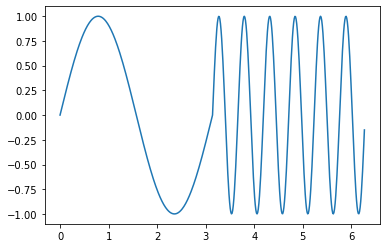

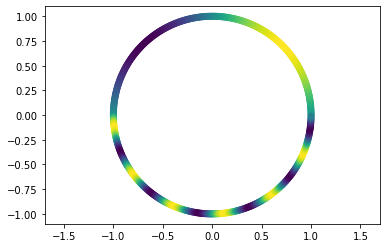

In [308]:
_,_ = make_circle_dataset(500, 2, 12, plot = True)

In [309]:

# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return idx

# temp = np.array(np.sort(np.arctan2(X[:,1],X[:,0])*180/np.pi), dtype = int)
# value1 = -100
# x1_idx = find_nearest(temp, value1)
# x2_idx = find_nearest(temp, value1+10)

# value2 = 70
# x3_idx = find_nearest(temp, value1)
# x4_idx = find_nearest(temp, value1+10)

**MLP**

In [310]:

# intermediate_outs_run.append(np.array((hidden_layer_outputs[1][[x1_idx, x2_idx, x3_idx, x4_idx]]).detach().to('cpu')))
# predictions_run.append(prediction)
# # print(np.array((hidden_layer_outputs[1][[x1_idx, x2_idx, x3_idx, x4_idx]]).detach().to('cpu')))
# kernels = get_kernels(hidden_layer_outputs)
# # YKYs =  YKYs = get_YKYs(kernels)
# model_learning_status = "Learned"
# # state_info["Y'KY"] = YKYs
# state_info["step"] = batch+1
# state_info["Run"] = str(run)
# state_info["epoch"] = "{:03}".format(epoch)
# state_info["loss"] = float("{:.3f}".format(loss))
# state_info["model_learning_status"] = "Learned"
# kernels_over_batches.append(kernels)
# state_info_over_batches.append(state_info.copy())

In [311]:
class NeuralNet(nn.Module):
  def __init__(self, n_hidden_layers, n_neurons, protocol_type, bias):
        super(NeuralNet, self).__init__()
        
        self.protocol_type = protocol_type
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.bias = bias
        self.flatten = nn.Flatten()
        self.layers = nn.ModuleList([nn.Linear(784,  self.n_neurons, bias = self.bias).to(device)])
        
        for i in range(self.n_hidden_layers-1):
          self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons, bias = self.bias ).to(device))

        self.layers.append(nn.Linear( self.n_neurons, 10, bias = self.bias).to(device))
  def forward(self, x, batch = None):
        x = self.flatten(x)
     

        hidden_layer_outputs = []
        for i in range(len(self.layers)-1):
          x = self.layers[i](x)
          out = torch.relu(x)
          hidden_layer_outputs.append(out)
          x = out
        x = self.layers[-1](x)
        return x, hidden_layer_outputs
        

**Visualizing Kernels for MLP**

In [312]:
def plot_heatmap(K, YKYs, state_info, all_input = True, save_fig = True, show_fig = False):
  # plt.figure(figsize = (15,500))
  f, axes = plt.subplots(1, len(K),figsize = (15*8,15))
  
  for i in range(len(K)):
    if all_input:
      ax = sns.heatmap(K[i][0:500:5,0:500:5], linewidth=.2, ax = axes[i])
    else:
      ax =sns.heatmap(K[i][[x1_idx, x2_idx, x3_idx, x4_idx]][:,[x1_idx, x2_idx, x3_idx, x4_idx]], linewidth=.2, ax = axes[i])
    
    model_title = state_info["model_protocol_type"] +'(' + 'n_h_l = '+ str(state_info["n_hidden_layers"])+ ', n_n = '+ str(state_info["n_neurons"])+','+ 'Run=' + str(state_info["run"])+',' +'Epoch = '+str(state_info['epoch'])+','+'step='+ str(state_info['step']) +',' +state_info['learning_status']+ ','+ "loss = " + str(state_info['loss'])   +')'
    if i < len(K)-1:
      title = 'K'+str(i+1)+ ', ' +"Y'KY_n = "+ YKYs[i] 
      ax.set_xlabel(title, fontsize = 75)
      pass
    else:
      title = 'K'+', ' +"Y'KY_n = "+  YKYs[i] 
      ax.set_xlabel(title, fontsize = 75)

  plt.suptitle(model_title,x = 0.5, y = 1.05,ha = 'center', fontsize = 90, fontweight = 20)
  if save_fig:
    plt.savefig(model_title + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
  if show_fig:
    plt.show()  
  plt.clf()
  plt.close(f)

In [313]:

def format_state_info(state_info):
  state_info["run"] = str(state_info["run"])
  state_info["epoch"] = f'{int(state_info["epoch"]):03d}'
  state_info["step"] = f'{int(state_info["step"]):02d}'
  state_info["loss"] = float("{:.3f}".format(state_info["loss"]))
  state_info["learning_status"] = state_info["learning_status"]
  return state_info


def routine(hidden_layer_outs_container, state_info_container, predictions_container,  hidden_layer_outputs,state_info, predictions):

  hidden_layer_outs_container.append(hidden_layer_outputs)
  state_info_container.append(copy.deepcopy(state_info))
  predictions_container.append(predictions)


In [314]:


def train(dataloader, model, loss_fn, optimizer,  dataloader_all = None, state_info = None):
    size = len(dataloader.dataset)
    correct = 0
    state_info_over_batches = []
    hidden_layer_outs_over_batches = []
    predictions_over_batches = []
    for batch, (x,y) in enumerate(dataloader):
        X, y = x.to(device), y.to(device)
        pred, _ = model(X.float())
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # loss = loss.item()
        if batch%100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")

        if int(state_info['epoch']) <= step_stop_point and (batch+1) % step_stepsize == 0:
          predictions, hidden_layer_outputs, loss = evaluate(dataloader_all,model, loss_fn)
          state_info.update({'step' : batch+1})
          state_info.update({'loss' : loss})
          state_info = format_state_info(state_info)
          routine(hidden_layer_outs_container = hidden_layer_outs_over_batches, state_info_container = state_info_over_batches, predictions_container = predictions_over_batches,
            hidden_layer_outputs = hidden_layer_outputs, state_info = state_info, predictions = predictions
            )
          # plot_heatmap(kernels, state_info)

    return predictions_over_batches, hidden_layer_outs_over_batches, state_info_over_batches

def evaluate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred , out = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    
    out = [x.clone().detach().to('cpu').numpy() for x in out]
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return pred, out, test_loss

In [315]:



# for n_h_l in [5]:
 
  # for n_n in [32]:
def run_mlp_model(train_dataloader, dataloader_all, n_h_l = 5,n_n = 32, n_runs = 5, n_epochs = 100, bias = True, is_mnist_data = None):
    model_protocol_type = "MLP"
    n_hidden_layers = n_h_l
    n_neurons = n_n

    state_info = {"model_protocol_type" : model_protocol_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}
    # kernel_5_runs = []
    
    # intermediate_outs_5_runs = []
    hidden_layer_outs_5_runs = []
    state_info_5_runs = []
    predictions_5_runs = []
    # rand_kernels_over_5 = []
    for run in range(n_runs):

      
     

      #model init
      mlp_model = NeuralNet( n_hidden_layers, n_neurons, model_protocol_type, bias).to(device)
      loss_fn = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(mlp_model.parameters(),lr = 3e-3)  

      #Local variables init
      # model_learning_status = "UnLearned"
      # kernels_run = []
      hidden_layer_outs_run = []
      state_info_run = []
      # intermediate_outs_run = []
      predictions_run = []
      epochs = n_epochs


      #Evaluate before training starts
      predictions, hidden_layer_outputs, loss = evaluate(dataloader_all,mlp_model, loss_fn)
      # print(torch.argmax(nn.Softmax(dim = 1)(predictions), dim = 1))
      # debug()
      state_info.update({'run' : run+1, 'epoch' : 0,'step' : 0,'loss' : loss,'learning_status' : 'UnLearned'})
      state_info = format_state_info(state_info)
      routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,
              hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions]
              )
      # print(state_info_run)
      # hidden_layer_outs_run.append([hidden_layer_outputs])
      # state_info_run.append([state_info.copy()])
      # predictions_run.append([predictions])
      # print(state_info)
      # debug()
      #Store init result
      # kernels_run.append([kernels])
      # state_info_run.append([state_info.copy()])
      # intermediate_outs_run.append(np.array((hidden_layer_outputs[1][[x1_idx, x2_idx, x3_idx, x4_idx]]).detach().to('cpu')))
     

      for epoch in range(epochs):
          print(f"Epoch {epoch+1}\n-------------------------------")
          state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : None,'loss' : loss,'learning_status' : 'Learned'})
          predictions_batches, hidden_layer_outs_batches, state_info_batches = train(train_dataloader,mlp_model, loss_fn, optimizer,
                                                           dataloader_all = dataloader_all, state_info = state_info)
          
          
          if int(state_info['epoch']) <= step_stop_point: 
            # hidden_layer_outs_run.append(hidden_layer_outs_batches)
            # state_info_run.append(state_info_batches)
            # predictions_run.append(predictions_batches)
            routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,
                    hidden_layer_outputs = hidden_layer_outs_batches, state_info = state_info_batches, predictions = predictions_batches
                    )
          # else: #int(state_info['epoch']) > 2:
          elif int(state_info['epoch']) <= epoch_stop_point or (int(state_info['epoch']) % epoch_stepsize) == 0:
            predictions, hidden_layer_outputs, loss = evaluate(dataloader_all,mlp_model, loss_fn)
            state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : n_batches,'loss' : loss,'learning_status' : 'Learned'})
            state_info = format_state_info(state_info)
            routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,
                    hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions]
                    )
            # hidden_layer_outs_run.append([hidden_layer_outputs])
            # state_info_run.append([state_info.copy()])
            # predictions_run.append([predictions])

            

          # print(state_info_run)
            
          

    # intermediate_outs_5_runs.append(intermediate_outs_run)
    # kernel_5_runs.append(kernels_run)
      state_info_5_runs.append(state_info_run)
      hidden_layer_outs_5_runs.append(hidden_layer_outs_run)
      predictions_5_runs.append(predictions_run)

    return hidden_layer_outs_5_runs, state_info_5_runs, predictions_5_runs

In [316]:
class NPFNeuralNetwork(nn.Module):
    def __init__(self, n_hidden_layers, n_neurons, protocol_type, bias):
        super(NPFNeuralNetwork, self).__init__()
        self.protocol_type = protocol_type
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.bias = bias
        
        self.layers = nn.ModuleList([])
   
        #For DLGN-SF, DGN-DLGN-SF
        if self.protocol_type == "DLGN-SF":
          self.layers.append(nn.Linear(2,  self.n_neurons, bias = self.bias).to(device))
          for i in range(self.n_hidden_layers-1):
            self.layers.append(nn.Linear( 2,  self.n_neurons, bias = self.bias).to(device))
            
        elif self.protocol_type == "DGN-DLGN-SF":
          self.layers.append(nn.Sequential(nn.Linear(2,  self.n_neurons, bias = self.bias).to(device),
                                            nn.ReLU(),
                                            nn.Linear(self.n_neurons,  self.n_neurons, bias = self.bias).to(device)
                                            )
                            )
          
          for i in range(self.n_hidden_layers-1):
            self.layers.append(nn.Sequential(
                                  nn.Linear( 2,  self.n_neurons, bias = self.bias).to(device),
                                  nn.ReLU(),
                                  nn.Linear(self.n_neurons,  self.n_neurons, bias = self.bias).to(device)
                              )
                        )
        #For DGN, DLGN
        else: 
          self.layers.append(nn.Linear(2,  self.n_neurons, bias = self.bias).to(device))
          for i in range(self.n_hidden_layers-1):
            self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons, bias = self.bias).to(device))
        
        
        
        # self.layers.append(nn.Linear( self.n_neurons, 1, bias = False).to(device))
  
        
    def forward(self, x):
        hidden_layer_outputs = []
      
        if self.protocol_type == "DGN":
          for i in range(len(self.layers)):
            x = self.layers[i](x)
            out = torch.relu(x)
            hidden_layer_outputs.append(out)
            x = out
          #x = self.layers[len(layers)-1](x)

        elif  self.protocol_type == "DLGN":
          for i in range(len(self.layers)):
            x = self.layers[i](x)
            out = x
            hidden_layer_outputs.append(out)
            x = out
          #x = self.layers[len(layers)-1](x)

        elif  self.protocol_type == "DLGN-SF":
          for i in range(len(self.layers)):
            out = self.layers[i](x)
            hidden_layer_outputs.append(out)
        elif  self.protocol_type == "DGN-DLGN-SF":
          for i in range(len(self.layers)):
            out = self.layers[i](x) 
            hidden_layer_outputs.append(out)
        

        return hidden_layer_outputs



class NPVNeuralNetwork(nn.Module):
    def __init__(self, n_hidden_layers, n_neurons, bias):
        super(NPVNeuralNetwork, self).__init__()
  
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.bias = bias
        self.layers = nn.ModuleList([nn.Linear(2,  self.n_neurons, bias = self.bias).to(device)])
      
        for i in range(self.n_hidden_layers-1):
          self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons, bias = self.bias).to(device))
          
        self.layers.append(nn.Linear( self.n_neurons, 1, bias = self.bias).to(device))

        self.gate = Gate()
      
    def forward(self, x,act_type, gating_mask):
        hidden_layer_outputs = []
        for i in range(len(self.layers)-1):
          x = self.layers[i](x)
          
          out = self.gate(act_type, x, i, gating_mask)
          
          hidden_layer_outputs.append(out)
          x = out
        x = self.layers[len(self.layers)-1](x)
        #print("debug 2", x.shape, x)
        return x,  hidden_layer_outputs


def apply_gate(beta, idx, gating_mask):
  out = beta*(gating_mask[idx])
  
  return out
  
class Gate(nn.Module):
    def __init__(self, beta = 4):
        super(Gate,self).__init__()
        self.beta = beta

    def forward(self,act_type, x, idx, gating_mask):
      #Soft Relu
      if act_type == 'soft':
        return torch.mul(x,torch.sigmoid(apply_gate(self.beta, idx,gating_mask)))
      elif act_type == 'hard':
      #Hard Relu
        temp = torch.sign(gating_mask[idx])
        temp[temp <= 0] = 0
        return torch.mul(x,temp)



def train_decoupled(X1_dataloader,X2_dataloader, npf_model, npv_model, loss_fn, optimizer, dataloader_all = None, state_info = None):
    size = len(X1_dataloader.dataset)
    correct = 0
    state_info_over_batches = []
    hidden_layer_outs_over_batches = []
    predictions_over_batches = []

    if int(state_info['epoch']) <= 2:
      act_type = 'soft'
    elif int(state_info['epoch']) > 2:
      act_type = 'soft'
    else:
      print("Some error")

    for batch, ((X1, y1), (X2,y2)) in enumerate(zip(X1_dataloader, X2_dataloader)):
        X1, y1 = X1.to(device), y1.to(device)
        X2, y2 = X2.to(device), y2.to(device)
        
        npf_model_hidden_layer_outs = npf_model(X1)
        pred, npv_model_hidden_layer_outs = npv_model(X2,act_type, npf_model_hidden_layer_outs)
        #print("Debug1 ", pred.shape)
        loss = loss_fn(pred, y1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch%10 == 0:
        #     #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        #     loss, current = loss.item(), batch * len(X1)
        #     print(f"loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")
        if int(state_info['epoch']) <= 2:
          predictions, hidden_layer_outputs, loss = evaluate_decoupled(dataloader_all,npf_model, npv_model, loss_fn)
          state_info.update({'step' : batch+1})
          state_info.update({'loss' : loss})
          state_info = format_state_info(state_info)
          routine(hidden_layer_outs_container = hidden_layer_outs_over_batches, state_info_container = state_info_over_batches, predictions_container = predictions_over_batches,
            hidden_layer_outputs = hidden_layer_outputs, state_info = state_info, predictions = predictions
            )
        
    return predictions_over_batches, hidden_layer_outs_over_batches, state_info_over_batches

def evaluate_decoupled(dataloader, npf_model, npv_model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    npf_model.eval()
    npv_model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            npf_model_hidden_layer_outs = npf_model(X)
            pred, npv_model_hidden_layer_outs = npv_model(X,'soft', npf_model_hidden_layer_outs)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    npf_model_hidden_layer_outs = [x.clone().detach().to('cpu').numpy() for x in npf_model_hidden_layer_outs]
    print(f"Loss over all data : {test_loss:>5f} \n")
    return pred, npf_model_hidden_layer_outs, test_loss



In [317]:


def run_npf_npv_model(train_dataloader, dataloader_all, protocol = 'DGN', n_h_l = 5,n_n = 32, n_runs = 5, n_epochs = 250, bias = True):

    model_protocol_type = protocol
    n_hidden_layers = n_h_l
    n_neurons = n_n

    state_info = {"model_protocol_type" : model_protocol_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}
    hidden_layer_outs_5_runs = []
    state_info_5_runs = []
    predictions_5_runs = []
    
    for run in range(n_runs):
      
      #Model Init
      npf_model = NPFNeuralNetwork(n_hidden_layers, n_neurons, model_protocol_type, bias).to(device)
      npv_model = NPVNeuralNetwork(n_hidden_layers, n_neurons, bias).to(device)
      torch.save(npv_model.state_dict(), "npv_init_weights")

      loss_fn = nn.MSELoss()
      optimizer = torch.optim.Adam([
                      {'params': npf_model.parameters()},
                      {'params': npv_model.parameters()}],
                      lr = 3e-3) 
      
      #Make the non linear layer of NPF model untrainable
      #NOTE: Unchecked for different hidden layers(Currently working for n_h_l = 5)
      if model_protocol_type == 'DGN-DLGN-SF':
        for idx, param in enumerate(npf_model.parameters()):
          if idx % 4 == 0 or idx-1 % 4 == 0:
            param.requires_grad = False
      
      #Local Variable Init
      hidden_layer_outs_run = []
      state_info_run = []
      predictions_run = []
      epochs = n_epochs

      #Evaluate before training starts
      predictions, hidden_layer_outputs, loss =  evaluate_decoupled(dataloader_all,npf_model, npv_model, loss_fn)
      state_info.update({'run' : run+1, 'epoch' : 0,'step' : 0,'loss' : loss,'learning_status' : 'UnLearned'})
      state_info = format_state_info(state_info)
      routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,
              hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions]
              )

      for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : None,'loss' : loss,'learning_status' : 'Learned'})
        predictions_batches, hidden_layer_outs_batches, state_info_batches = train_decoupled(train_dataloader,train_dataloader,npf_model, npv_model, loss_fn, optimizer,
                                                                  dataloader_all = dataloader_all, state_info = state_info)
        

        if int(state_info['epoch']) <= 2: 
            routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,
                    hidden_layer_outputs = hidden_layer_outs_batches, state_info = state_info_batches, predictions = predictions_batches
                    )
        
        # else: #int(state_info['epoch']) > 2:
        elif int(state_info['epoch'])  <= 20:
            predictions, hidden_layer_outputs, loss =  evaluate_decoupled(dataloader_all,npf_model, npv_model, loss_fn)
            state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : 16,'loss' : loss,'learning_status' : 'Learned'})
            state_info = format_state_info(state_info)
            routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,
                    hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions]
                    )
        elif int(state_info['epoch'])  % 10 == 0:
            predictions, hidden_layer_outputs, loss =  evaluate_decoupled(dataloader_all,npf_model, npv_model, loss_fn)
            state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : 16,'loss' : loss,'learning_status' : 'Learned'})
            state_info = format_state_info(state_info)
            routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,
                    hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions]
                    )
        if int(state_info['epoch']) == 2:
              for idx, param in enumerate(npf_model.parameters()):
                  param.requires_grad = False
              npv_model.load_state_dict(torch.load("npv_init_weights"))
      state_info_5_runs.append(state_info_run)
      hidden_layer_outs_5_runs.append(hidden_layer_outs_run)
      predictions_5_runs.append(predictions_run)

    return hidden_layer_outs_5_runs, state_info_5_runs, predictions_5_runs
    

In [318]:
def get_start_point(epoch_stop_point, epoch_stepsize):
  for i in range(epoch_stop_point+1, 500):
    if i % epoch_stepsize == 0:
      return i


In [319]:
# from pyparsing.util import col
#-------------------------------------------------------Plotting Functions--------------------------------------------------------

#For step wise analysis
def plot_kernel_values_stepwise(kernel_name, kernel_5_runs, x_idxs_pair):
  kernel_map = {'K1':0, 'K2':1, 'K3':2,'K4':3, 'K5':4, 'K': 5}
  # labels = ['x1x1', 'x2x2', 'x3x3', 'x4x4', 'x1x2', 'x3x4']
  kernel_idx = kernel_map[kernel_name]

  f, axes = plt.subplots(1,len(kernel_5_runs),figsize = (7*len(kernel_5_runs), 7))
  if len(kernel_5_runs) == 1:
    axes = [axes]

  plt.suptitle(f'{kernel_name}_step',ha = 'center', fontsize = 15)
  
  for run in range(len(kernel_5_runs)):
    for idx, (row, col) in enumerate(x_idxs_pair):
      values = []
      for epoch in range(len(kernel_5_runs[run])):
        for step in range(len(kernel_5_runs[run][epoch])):
          values.append(kernel_5_runs[run][epoch][step][kernel_idx][row,col])
        if epoch == 2:
          break
      if idx < len(x_idxs_pair)/2:
        linestyle = 'solid'
        color = 'red'
      else:
        linestyle = 'dashed'
        color = 'blue'
      x = [0] + list(np.arange(step_stepsize, len(values)*step_stepsize, step_stepsize))
      axes[run].plot(x,values, linestyle = linestyle, color = color)
      axes[run].set_xlabel(f'Run {run+1}', fontsize = 12)

    line1 = Line2D([0,1],[0,1],linestyle='solid', color='r')
    line2 = Line2D([0,1],[0,1],linestyle='dashed', color='b')
    axes[run].legend([line1, line2],['low freq', 'high freq'], loc = 'best')
    
  plt.savefig(f'{kernel_name}_step' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
  plt.show()

#For epoch wise analysis
def plot_kernel_values_epochwise(kernel_name, kernel_5_runs, x_idxs_pair):
  kernel_map = {'K1':0, 'K2':1, 'K3':2,'K4':3, 'K5':4, 'K': 5}
  # labels = ['x1x1', 'x2x2', 'x3x3', 'x4x4', 'x1x2', 'x3x4']
  kernel_idx = kernel_map[kernel_name]

  f, axes = plt.subplots(1,len(kernel_5_runs),figsize = (7*len(kernel_5_runs), 7))
  if len(kernel_5_runs) == 1:
    axes = [axes]

  plt.suptitle(f'{kernel_name}_epoch',ha = 'center', fontsize = 15)
  
  for run in range(len(kernel_5_runs)):
    for idx, (row, col) in enumerate(x_idxs_pair):
      values = []
      for epoch in range(len(kernel_5_runs[run])):
          values.append(kernel_5_runs[run][epoch][-1][kernel_idx][row,col])
      if idx < len(x_idxs_pair)/2:
        linestyle = 'solid'
        color = 'red'
      else:
        linestyle = 'dashed'
        color = 'blue'
      x = [0] + list(np.arange(epoch_stepsize, len(values)*epoch_stepsize, epoch_stepsize))
      axes[run].plot(x,values, linestyle = linestyle, color = color)
      axes[run].set_xlabel(f'Run {run+1}', fontsize = 12)

    line1 = Line2D([0,1],[0,1],linestyle='solid', color='r')
    line2 = Line2D([0,1],[0,1],linestyle='dashed', color='b')
    axes[run].legend([line1, line2],['low freq', 'high freq'], loc = 'best')
    
  plt.savefig(f'{kernel_name}_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
  plt.show()

  # Plot Activation graph stepwise
def plot_stepwise_activations(hidden_layer_no, hidden_layer_outs_5_runs):
  temp = []
  y_label = ''
  NUM_COLORS = n_neurons
  LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
  NUM_STYLES = len(LINE_STYLES)
  cm = plt.get_cmap('gist_rainbow')

  hidden_layer_no = hidden_layer_no
  for run in range(len(hidden_layer_outs_5_runs)):
    f, axes = plt.subplots(1, 4,figsize = (7*5,7))
    values = []
    for epoch in range(len(hidden_layer_outs_5_runs[run])):
      for step in range(len(hidden_layer_outs_5_runs[run][epoch])):
        sub_h_l_outs = hidden_layer_outs_5_runs[run][epoch][step][hidden_layer_no-1][[x1_idx, x2_idx, x3_idx, x4_idx]]#[:,[x1_idx, x2_idx, x3_idx, x4_idx]]
        values.append(sub_h_l_outs)
      if epoch == 2:
        break

    values = np.array(values)
    # x = [0] + list(np.arange(step_stepsize, len(values[0])*step_stepsize, step_stepsize))
    plt.suptitle(f'Run {run+1} for Hidden Layer No. {hidden_layer_no}',ha = 'center', fontsize = 15)
    for i in range(4):
      lines = axes[i].plot(values[:][:,i])
      axes[i].set_title(f'x_{i+1}')
      axes[i].set_xlabel(f'Step', fontsize = 12)
      axes[i].set_ylabel(y_label, fontsize = 12)
      # axes[i].set_xticks(np.arange(0,len(values), 1.0))

      for j in range(NUM_COLORS):

        lines[j].set_color(cm(j//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))
        lines[j].set_linestyle(LINE_STYLES[j%NUM_STYLES])

      # axes[i].set_color(cm(i//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))
      # axes[i].set_linestyle(LINE_STYLES[i%NUM_STYLES])
    plt.savefig(f'Run_{run+1}_step.png',format = "png",bbox_inches='tight', dpi = 100)
    plt.show()

# Plot Activation graph epochwise
def plot_epochwise_activations(hidden_layer_no, hidden_layer_outs_5_runs):
  temp = []
  y_label = ''

  NUM_COLORS = n_neurons
  LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
  NUM_STYLES = len(LINE_STYLES)
  cm = plt.get_cmap('gist_rainbow')

  hidden_layer_no = hidden_layer_no
  for run in range(len(hidden_layer_outs_5_runs)):
    f, axes = plt.subplots(1, 4,figsize = (7*5,7))
    values = []
    for epoch in range(len(hidden_layer_outs_5_runs[run])):
        sub_h_l_outs = hidden_layer_outs_5_runs[run][epoch][-1][hidden_layer_no-1][[x1_idx, x2_idx, x3_idx, x4_idx]]
        values.append(sub_h_l_outs)
      
    values = np.array(values)
    plt.suptitle(f'Run {run+1} for Hidden Layer No. {hidden_layer_no}',ha = 'center', fontsize = 15)
    # x = [0] +list(np.arange(1, epoch_stop_point+1 , 1)) +list(np.arange(start_point, n_epochs+1, epoch_stepsize))
    for i in range(4):
      lines = axes[i].plot(values[:][:,i])
      axes[i].set_title(f'x_{i+1}')
      axes[i].set_xlabel(f'Epoch', fontsize = 12)
      axes[i].set_ylabel(y_label, fontsize = 12)
      axes[i].set_xticks(np.arange(0,len(values), 10.0))

      for j in range(NUM_COLORS):
        lines[j].set_color(cm(j//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))
        lines[j].set_linestyle(LINE_STYLES[j%NUM_STYLES])
    plt.savefig(f'Run_{run+1}_epoch.png',format = "png",bbox_inches='tight', dpi = 100)
    plt.show()


#For step wise loss analysis
def plot_stepwise_loss(state_info_5_runs):
  f, axes = plt.subplots(1, 5,figsize = (7*5,7))
  for run in range(len(state_info_5_runs)):
    values = []
    for epoch in range(len(state_info_5_runs[run])):
      for step in range(len(state_info_5_runs[run][epoch])):
        loss = state_info_5_runs[run][epoch][step]['loss']
        values.append(loss)
      if epoch == 2:
        break
    values = np.array(values)
    x = [0] + list(np.arange(step_stepsize, len(values)*step_stepsize, step_stepsize))
    plt.suptitle('Loss v/s step',ha = 'center', fontsize = 15)
    for i in range(len(values)):
      axes[run].plot(x,values)
      axes[run].set_title(f'Run {run+1}')
      axes[run].set_xlabel(f'Step', fontsize = 12)
      axes[run].set_ylabel(f'Loss', fontsize = 12)
      # axes[run].set_xticks(np.arange(0,len(values), 2.0))
      

  plt.savefig('loss_step' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
  plt.show()

# For epoch wise loss analysis
def plot_epochwise_loss(state_info_5_runs):
  f, axes = plt.subplots(1, 5,figsize = (7*5,7))
  for run in range(len(state_info_5_runs)):
    values = []
    for epoch in range(len(state_info_5_runs[run])):
      loss = state_info_5_runs[run][epoch][-1]['loss']
      values.append(loss)
      
    values = np.array(values)
    x = [0] +list(np.arange(1, epoch_stop_point+1 , 1)) +list(np.arange(start_point, n_epochs+1, epoch_stepsize))
    plt.suptitle('Loss v/s epoch',ha = 'center', fontsize = 15)
    for i in range(len(values)):
      axes[run].plot(x,values)
      axes[run].set_title(f'Run {run+1}')
      axes[run].set_xlabel(f'Epoch', fontsize = 12)
      axes[run].set_ylabel(f'Loss', fontsize = 12)
      # axes[run].set_xticks(np.arange(0,len(values), 10.0))

  plt.savefig('loss_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
  plt.show()



In [320]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_4_inp_idxs(X_sorted, point1_degrees = 40, point2_degrees = 300, diff_in_degrees = 10):

  temp = np.array([(angle + 2*np.pi)*180/np.pi if angle < 0 else angle*180/np.pi for angle in np.arctan2(X_sorted[:,1],X_sorted[:,0]) ], dtype = int)
  value1 = point1_degrees
  x1_idx = find_nearest(temp, value1)
  x2_idx = find_nearest(temp, value1+diff_in_degrees)

  value2 = point2_degrees
  x3_idx = find_nearest(temp, value2)
  x4_idx = find_nearest(temp, value2+diff_in_degrees)
  return x1_idx, x2_idx, x3_idx, x4_idx

def get_kernels(hidden_layer_outputs):
  hidden_layer_outputs = copy.deepcopy(hidden_layer_outputs)
  n_hidden_layer = len(hidden_layer_outputs)
  for i in range(n_hidden_layer):
    # print(np.array(hidden_layer_outputs[i]).shape)
    temp = np.sign(hidden_layer_outputs[i])
    temp[temp <= 0] = 0
    # print(temp)
    hidden_layer_outputs[i] = temp#.detach().to("cpu"))

  hidden_layer_kernels = []
  for i in range(n_hidden_layer):
    hidden_layer_kernels.append(np.matmul(hidden_layer_outputs[i],hidden_layer_outputs[i].T))

  lambda_matrix = hidden_layer_kernels[0]
  for i in range(1,n_hidden_layer):
    lambda_matrix = np.multiply(lambda_matrix, hidden_layer_kernels[i])
  
  kernels = hidden_layer_kernels + [lambda_matrix]
  
  return kernels
def get_YKYs(kernels):
  YKYs = []
  for i in range(len(kernels)):
    YKY = np.matmul(np.matmul(Y_sorted.T, kernels[i]), Y_sorted)
    eigen_vals = eigh(kernels[i], eigvals_only = True)
    YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
  return YKYs

def build_kernels(hidden_layer_outs_5_runs):
  h_l_o = hidden_layer_outs_5_runs
  kernel_5_runs = []
  for run in range(len(h_l_o)):
      kernel_epochs = []
      for epoch in range(len(h_l_o[run])):
        kernel_step = []
        for step in range(len(h_l_o[run][epoch])):
          kernels = get_kernels(h_l_o[run][epoch][step])
          kernel_step.append(kernels)
        kernel_epochs.append(kernel_step)
      kernel_5_runs.append(kernel_epochs)
  return kernel_5_runs


In [321]:
def plot_kernels(hidden_layer_outs_5_runs, state_info_5_runs,for_all_inputs = True, save_fig = True, show_fig = False):
  h_l_o = hidden_layer_outs_5_runs
  s_i = state_info_5_runs
  for run in range(1):
    for epoch in range(len(h_l_o[run])):
      for step in range(len(h_l_o[run][epoch])):
        kernels = get_kernels(h_l_o[run][epoch][step])
        YKYs = get_YKYs(kernels)
        plot_heatmap(kernels,YKYs, s_i[run][epoch][step], all_input = for_all_inputs, save_fig = save_fig, show_fig = show_fig)
      if (not for_all_inputs) and epoch == 2:
        print(run, epoch)
        break

In [322]:

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext', 
            },
          });
        </script>
        '''))

def plot_y_prediction(Y_sorted, predictions_run):
  init_notebook_mode(connected=True)

  #from plotly sliders
  data = [dict(
          visible = False,
          line=dict(color='#00CED1', width=2),
          name = '𝜈 = '+str("step"),
          x = np.arange(0,500,1),
          y = d.to('cpu').flatten(),
          #  y =Y_sorted.flatten()
        ) for d in predictions_run]
  data[10]['visible'] = True

  data2 = [dict(
          visible = False,
          line=dict(color='#00CED1', width=2),
          name = '𝜈 = '+str("step"),
          x = np.arange(0,500,1),
          y = Y_sorted.flatten(),
        ) for d in predictions_run]
  data[10]['visible'] = True

  #configure added to visualize in colab
  configure_plotly_browser_state()

  steps = []
  for i in range(len(data)):
      step = dict(
          method = 'restyle',  
          args = ['visible', [False] * len(data)],
      )
      step['args'][1][i] = True # Toggle i'th trace to "visible"
      steps.append(step)

  sliders = [dict(
      active = 10,
      currentvalue = {"prefix": "Frequency: "},
      pad = {"t": 50},
      steps = steps
  )]

  layout = dict(sliders=sliders)

  fig = dict(data=data, layout=layout)

  fig2 = dict(data=data2, layout=layout)
  configure_plotly_browser_state()

  iplot(fig, filename='Sine Wave Slider')
  iplot(fig2, filename='Sine Wave Slider')


In [323]:
def save_results(file_name):
  os.system(f"zip -R {file_name}.zip '*.png'")
  os.system('mkdir All_Protocols')
  os.system(f'mv {file_name}.zip /content/All_Protocols')
  os.system("rm *")

def download_results():
  path = '/content/All_Protocols/'
  for f in os.listdir(path):
    files.download(f'{path}{f}')

In [324]:
def get_input_idxs():
  rng = np.random.default_rng(0)
  low_freq_idxs = sorted(rng.choice(np.arange(0, 250),10, replace = False))
  high_freq_idxs = sorted(rng.choice(np.arange(250, 500),10, replace = False))
  x_idxs = low_freq_idxs + high_freq_idxs
  x_idxs_pair = [(idx, idx) for idx in x_idxs]
  return x_idxs_pair

In [325]:

'''
 a := Number of half cycles in the top half of the circle
 b := number of half cycles in the bottom half of the circle
 For a, b = 1, 9:
  MLP takes 60 epochs
  DGN takes 130 epochs
  DLGN takes 80 epochs
  DLGN takes 70 epochs
  DLGN takes 70 epochs
'''
n_epochs = 100


step_stop_point = 2 #currently works for only 2
step_stepsize = 50
epoch_stop_point = 100
epoch_stepsize = 1
start_point = get_start_point(epoch_stop_point, epoch_stepsize)
# n_data_points = 500
# a, b = 1,9
# point1_degrees, point2_degrees, diff_in_degrees = 40, 300, 10
seed = 0
set_seed(seed = seed)

train_dataloader, dataloader_all, Y_sorted = get_mnist_dls(batch_size = 64, is_perturbed = True)
n_batches = len(train_dataloader)
Y_sorted = np.array(Y_sorted).reshape((len(Y_sorted), 1))

x_idxs_pair = get_input_idxs()


n_hidden_layers,  n_neurons, n_runs =  5, 64, 5
save_result = True

#Available Protocols : MLP, DGN, DLGN, DLGN-SF, DGN-DLGN-SF
# protocols = ['MLP', "DGN", 'DLGN', 'DLGN-SF','DGN-DLGN-SF']
# protocols = ['DLGN', 'DLGN-SF','DGN-DLGN-SF']
protocols = ['MLP']

bias = True
for protocol in protocols:
  set_seed(seed = seed)
  if protocol == 'MLP':
    hidden_layer_outs_5_runs, state_info_5_runs, predictions_5_runs = run_mlp_model(train_dataloader=train_dataloader,
                                                                                    dataloader_all = dataloader_all,
                                                                                    n_h_l = n_hidden_layers,
                                                                                    n_n = n_neurons,
                                                                                    n_runs = n_runs, n_epochs = n_epochs, bias = bias, is_mnist_data = True)
  else:
    hidden_layer_outs_5_runs, state_info_5_runs, predictions_5_runs = run_npf_npv_model(train_dataloader=train_dataloader,
                                                                                        dataloader_all = dataloader_all,
                                                                                        protocol = protocol,
                                                                                        n_h_l = n_hidden_layers,
                                                                                        n_n = n_neurons,
                                                                                        n_runs = n_runs,
                                                                                        n_epochs = n_epochs, bias = bias)



Streaming output truncated to the last 5000 lines.
loss: 0.582116 Batch:800 [51200/60000]
loss: 0.793711 Batch:900 [57600/60000]
Test Error: 
 Accuracy: 59.2%, Avg loss: 0.809768 

Epoch 89
-------------------------------
loss: 0.932245 Batch:0 [    0/60000]
loss: 1.076763 Batch:100 [ 6400/60000]
loss: 0.780592 Batch:200 [12800/60000]
loss: 0.931429 Batch:300 [19200/60000]
loss: 0.805832 Batch:400 [25600/60000]
loss: 0.955894 Batch:500 [32000/60000]
loss: 0.710349 Batch:600 [38400/60000]
loss: 0.766143 Batch:700 [44800/60000]
loss: 1.055441 Batch:800 [51200/60000]
loss: 0.982345 Batch:900 [57600/60000]
Test Error: 
 Accuracy: 58.2%, Avg loss: 0.813771 

Epoch 90
-------------------------------
loss: 0.799739 Batch:0 [    0/60000]
loss: 0.737960 Batch:100 [ 6400/60000]
loss: 0.841654 Batch:200 [12800/60000]
loss: 0.959998 Batch:300 [19200/60000]
loss: 0.782516 Batch:400 [25600/60000]
loss: 0.952140 Batch:500 [32000/60000]
loss: 0.759090 Batch:600 [38400/60000]
loss: 0.749302 Batch:700 [

In [228]:
kernel_5_runs = build_kernels(hidden_layer_outs_5_runs)


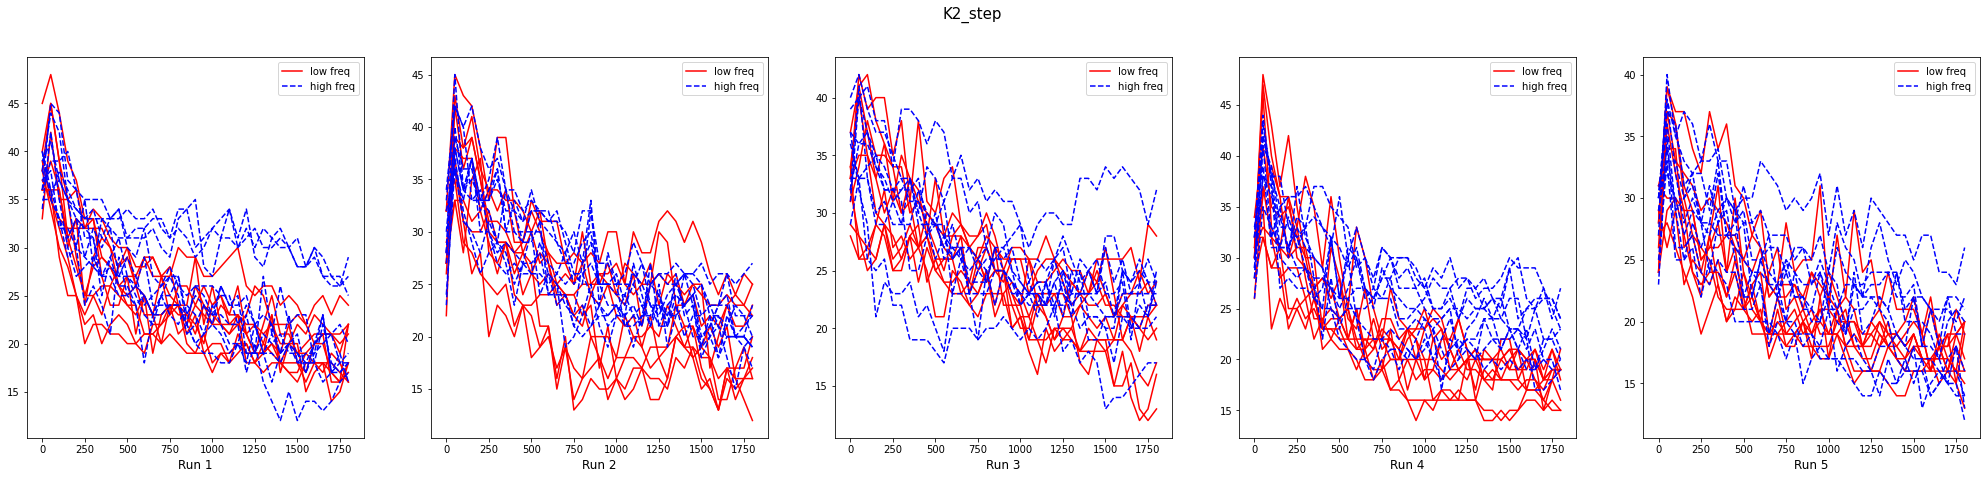

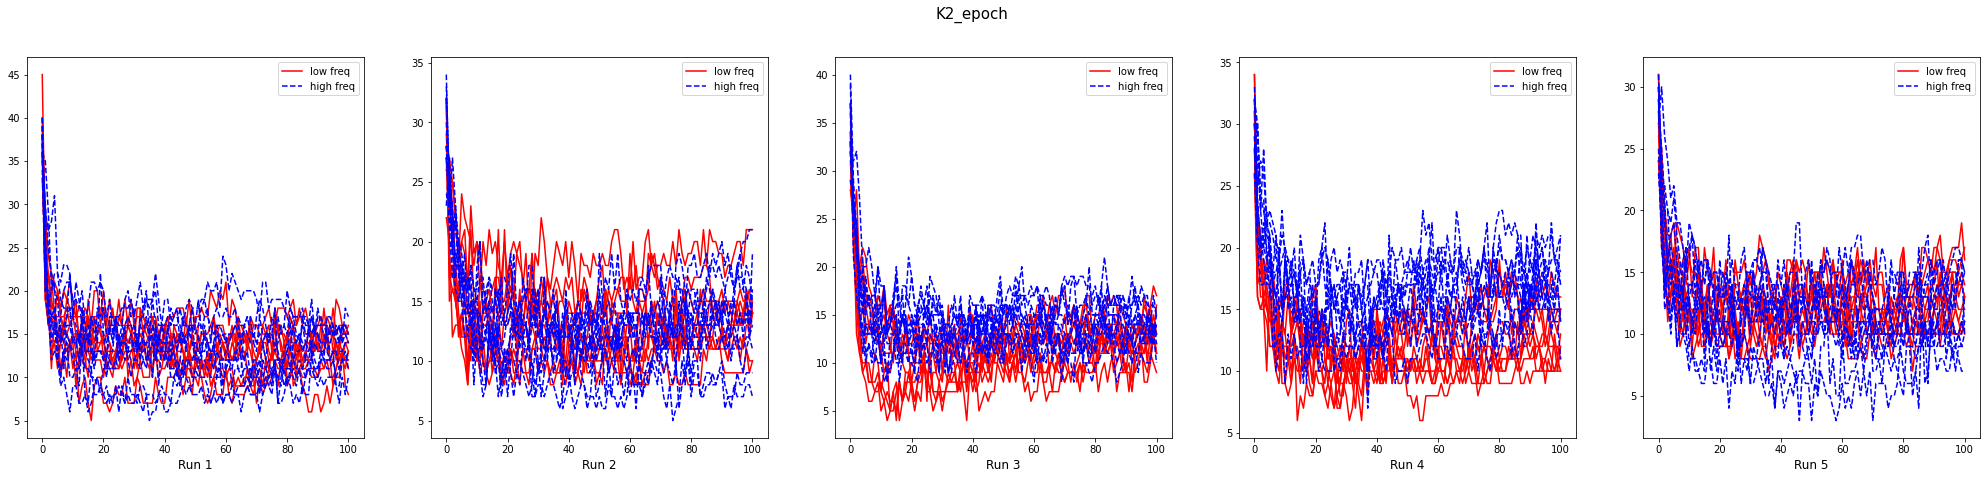

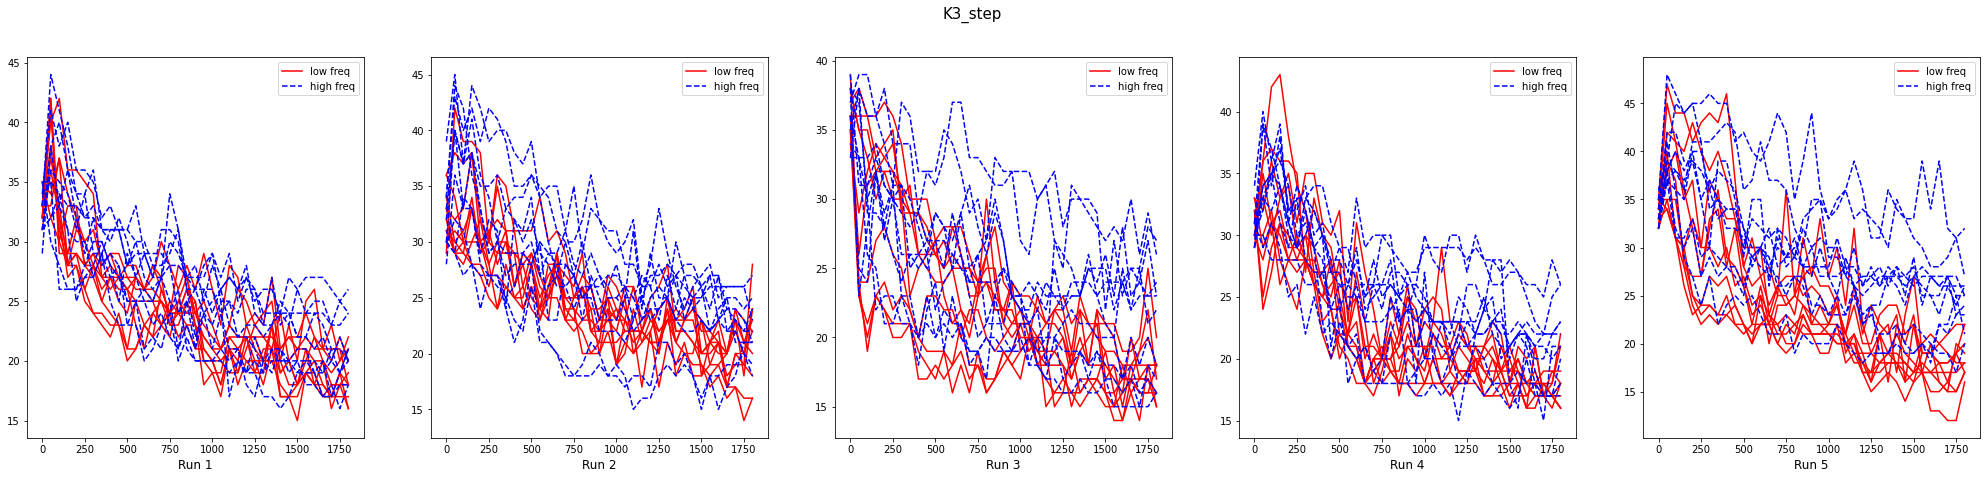

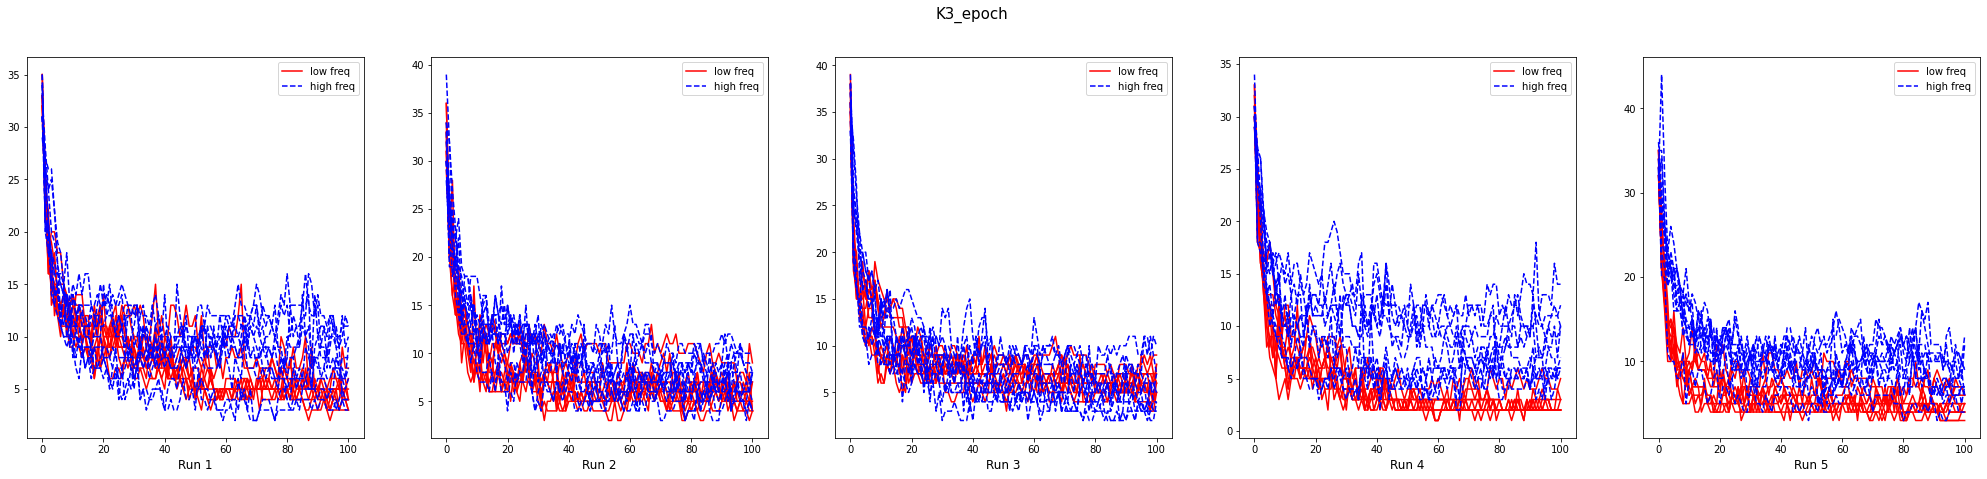

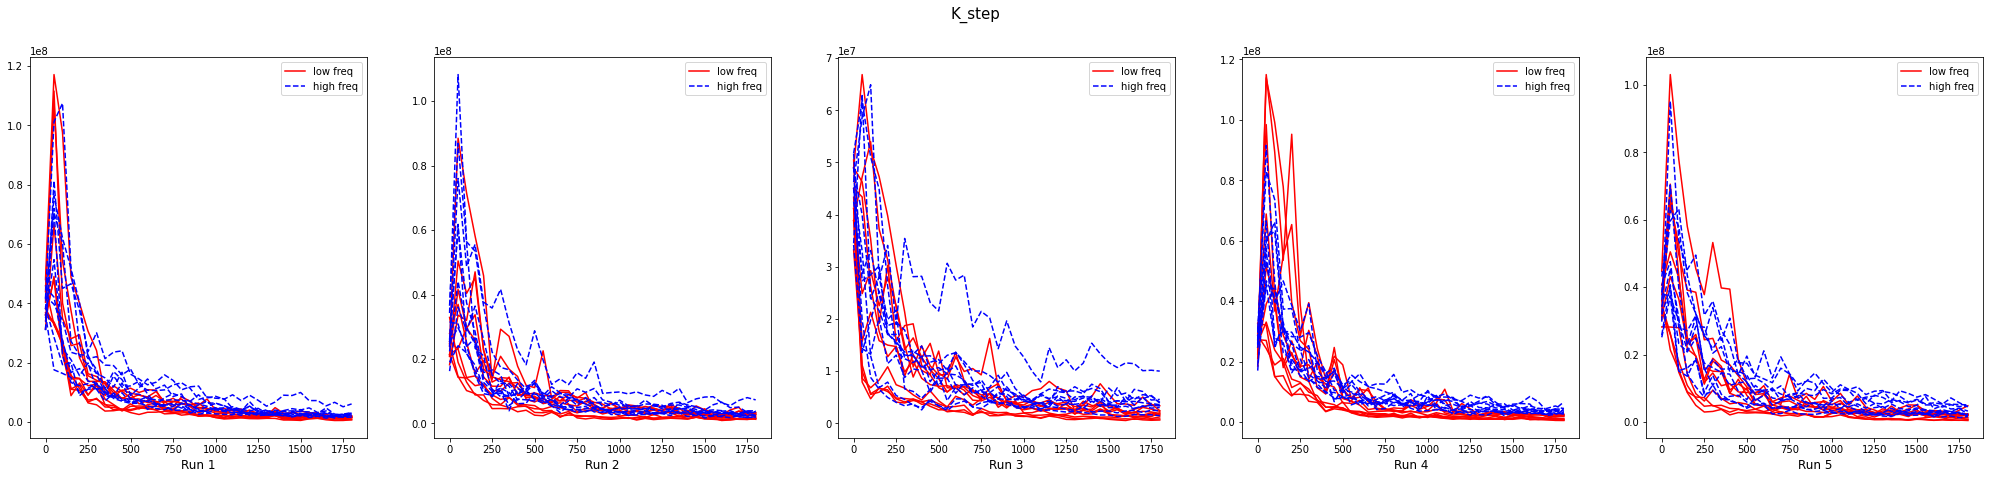

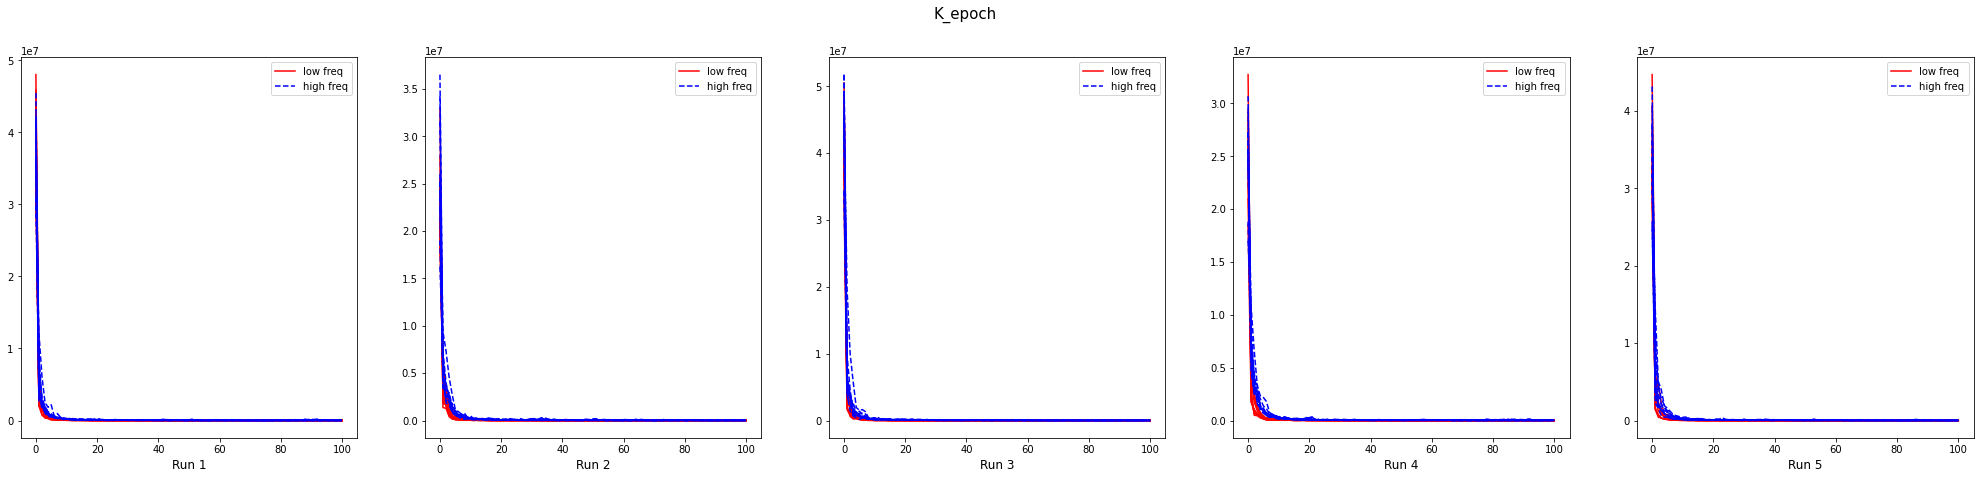

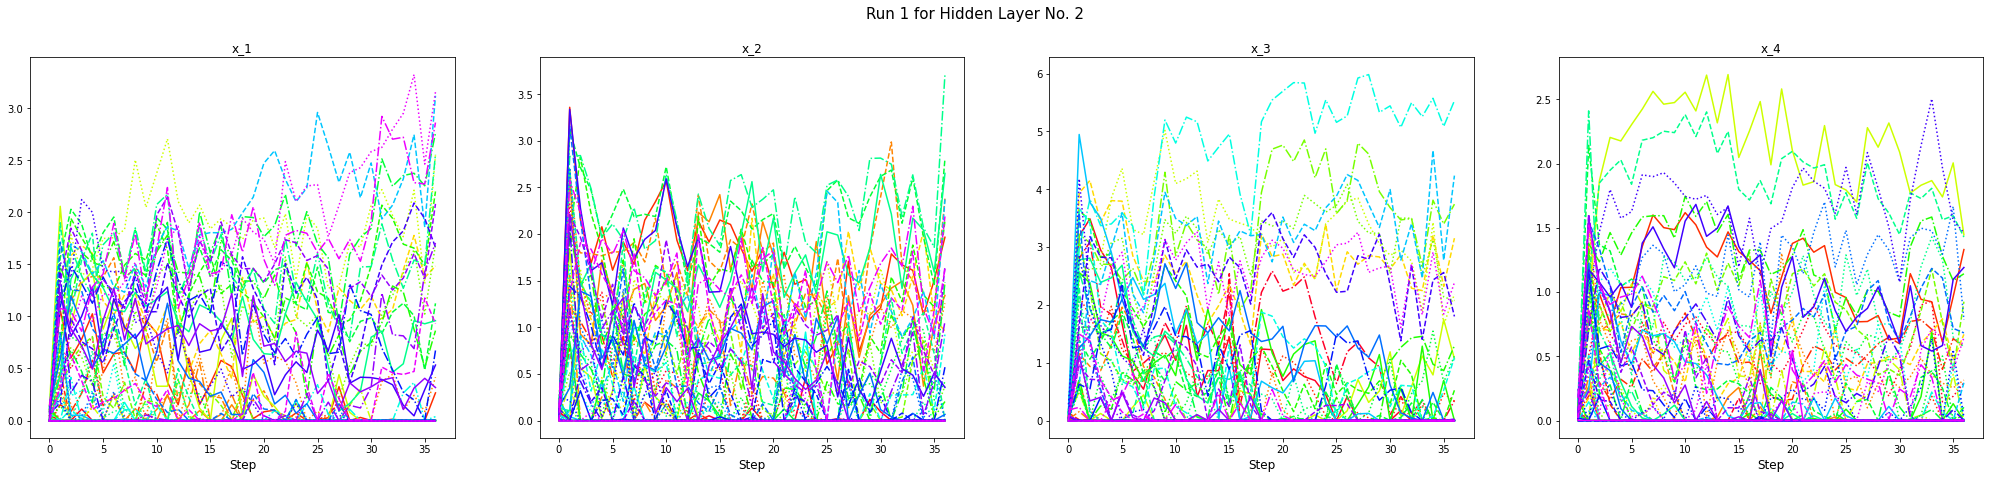

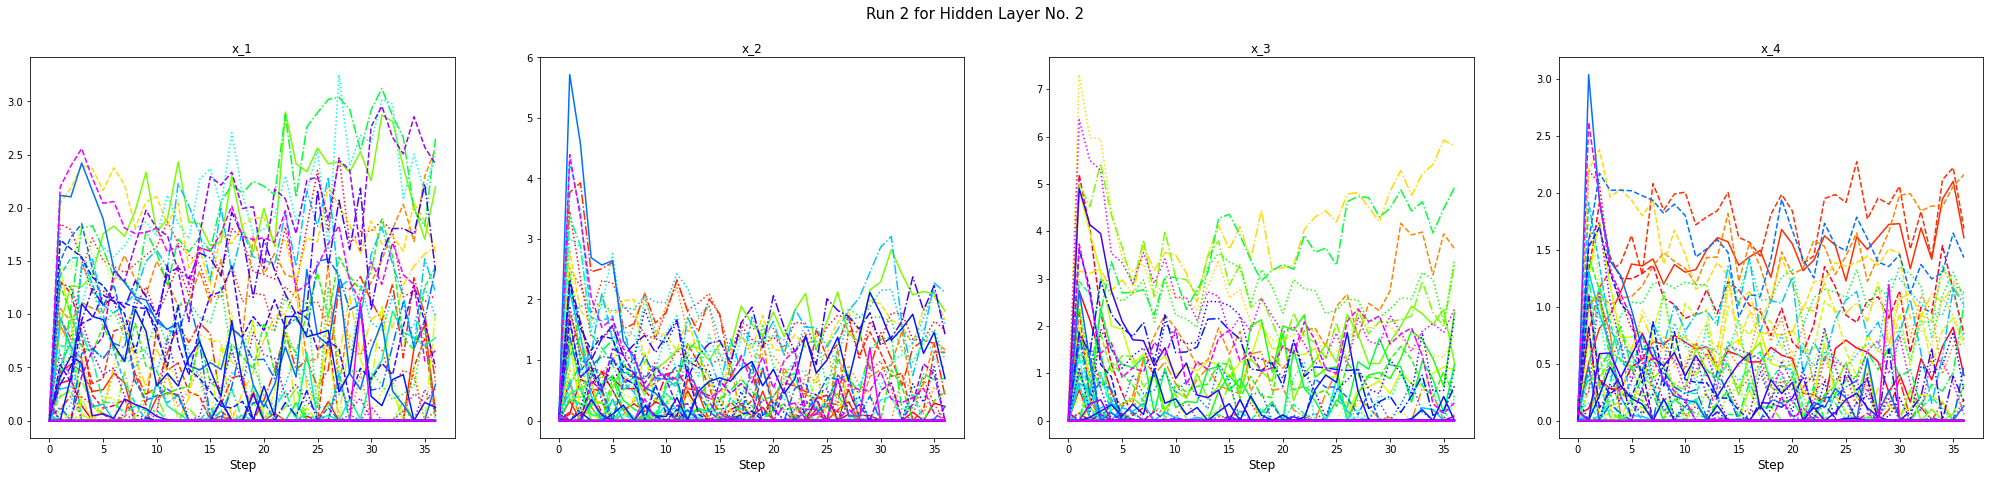

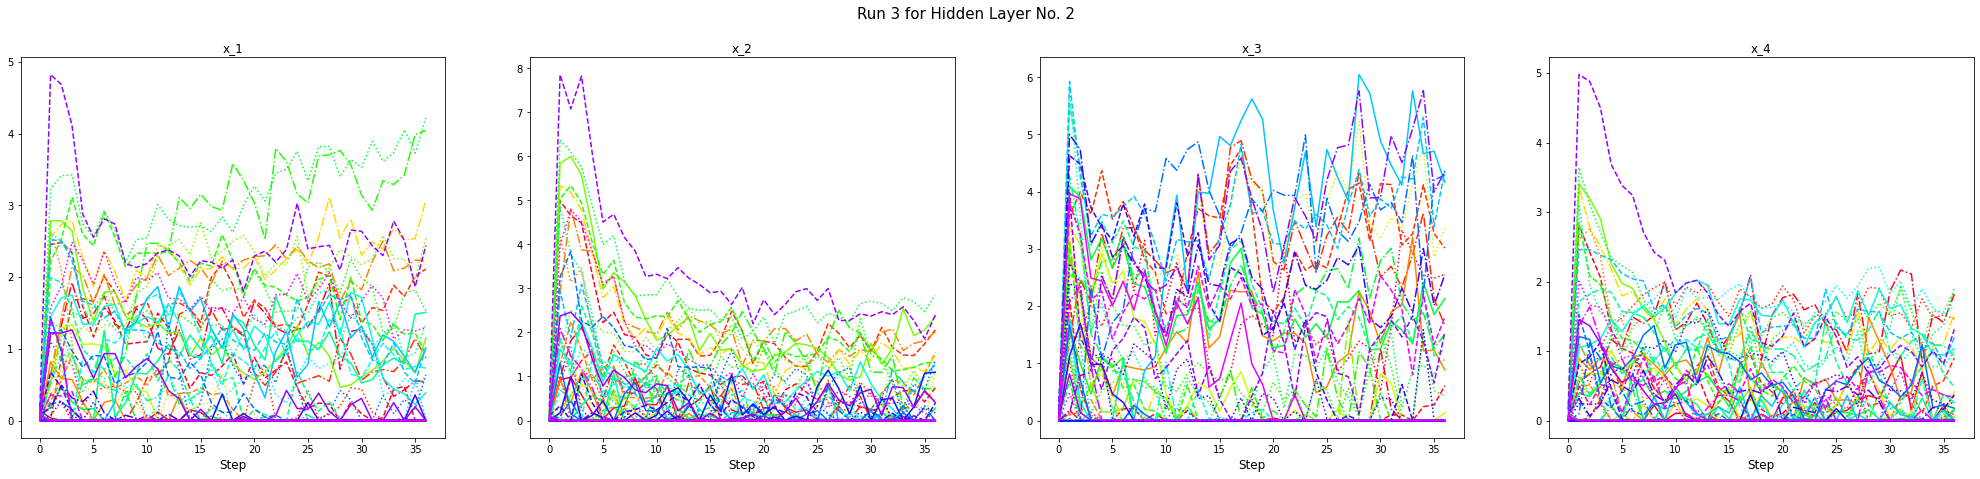

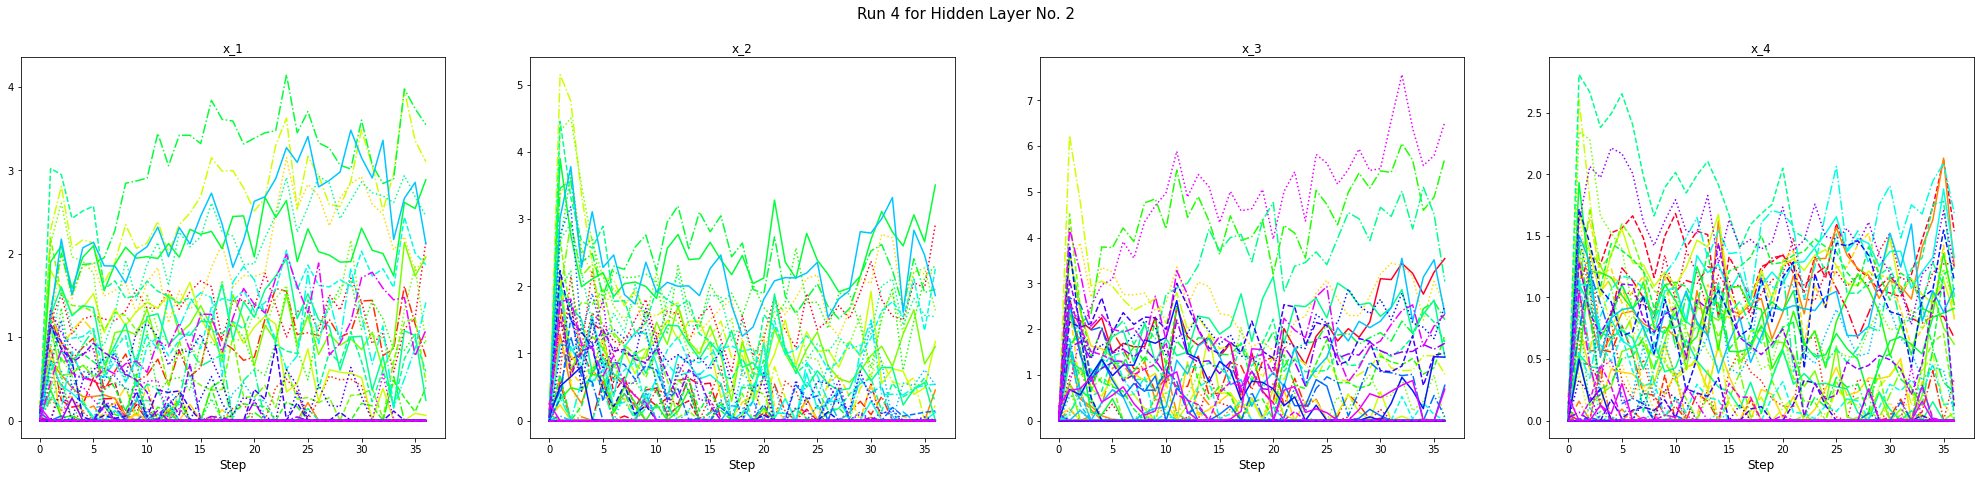

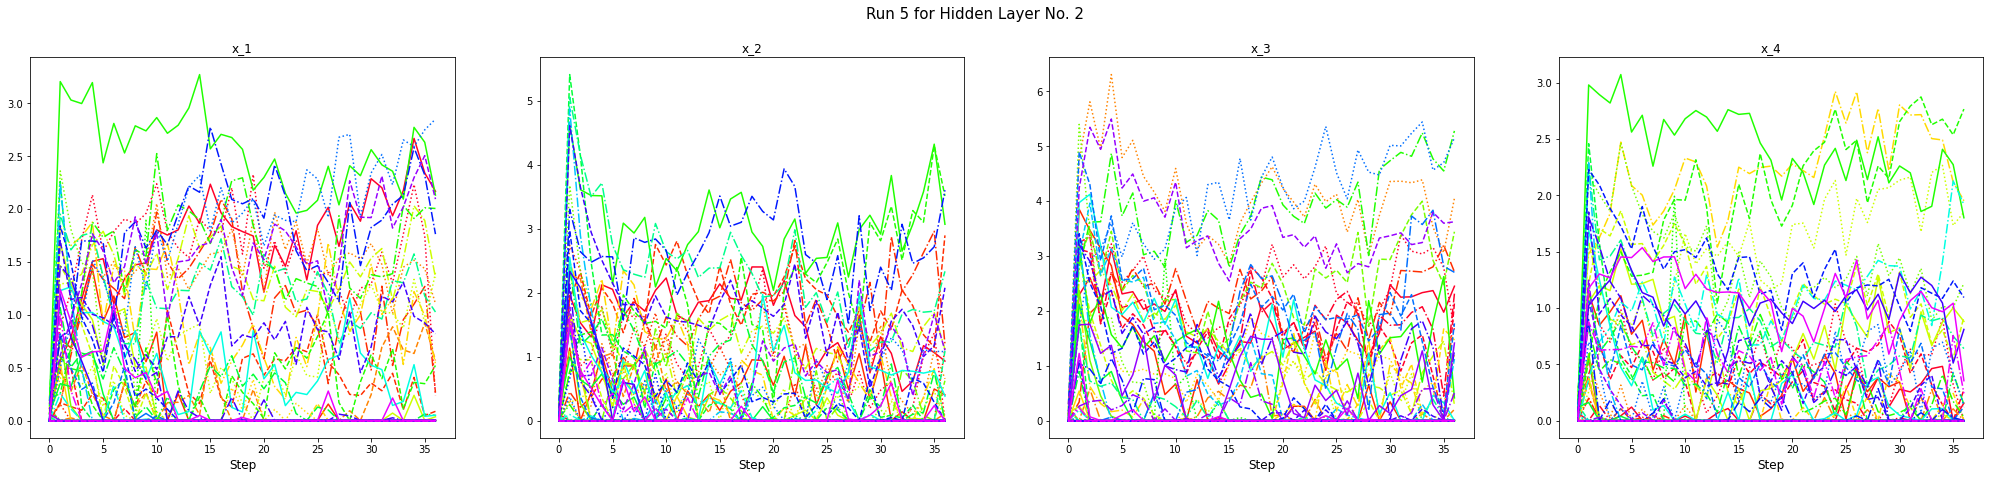

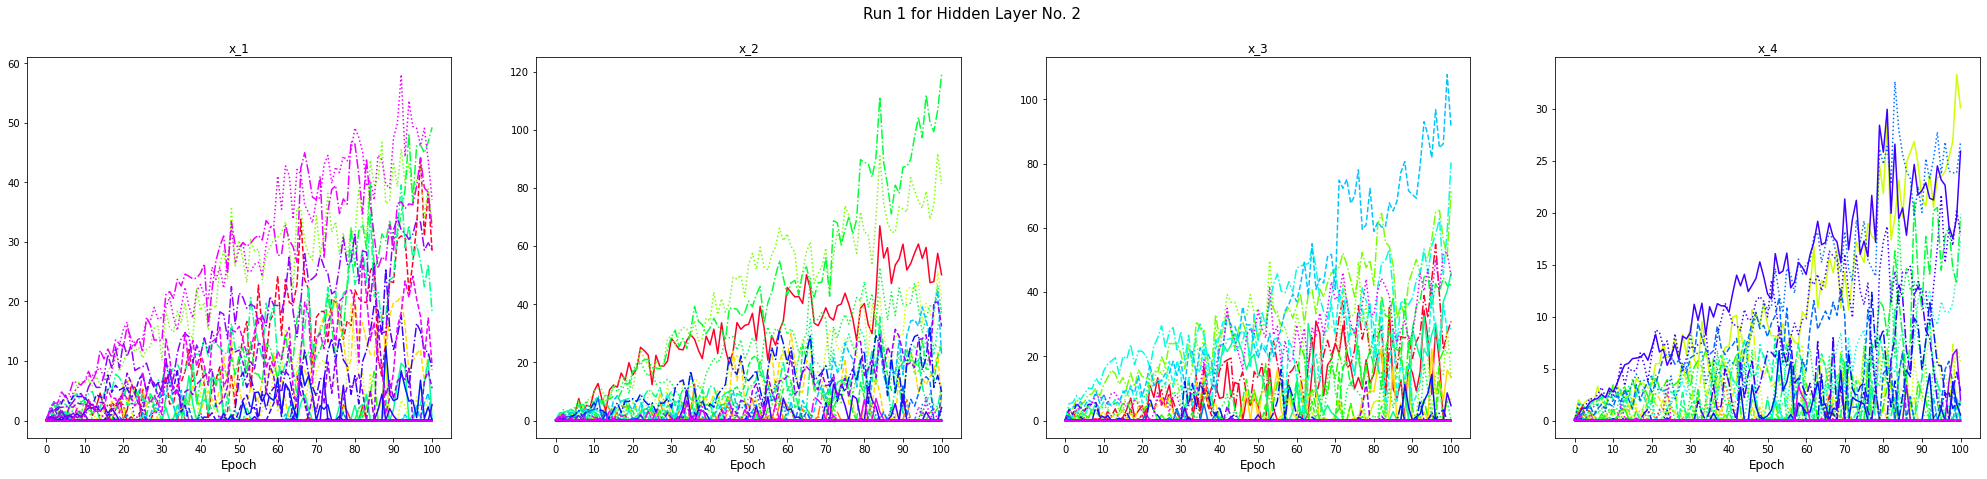

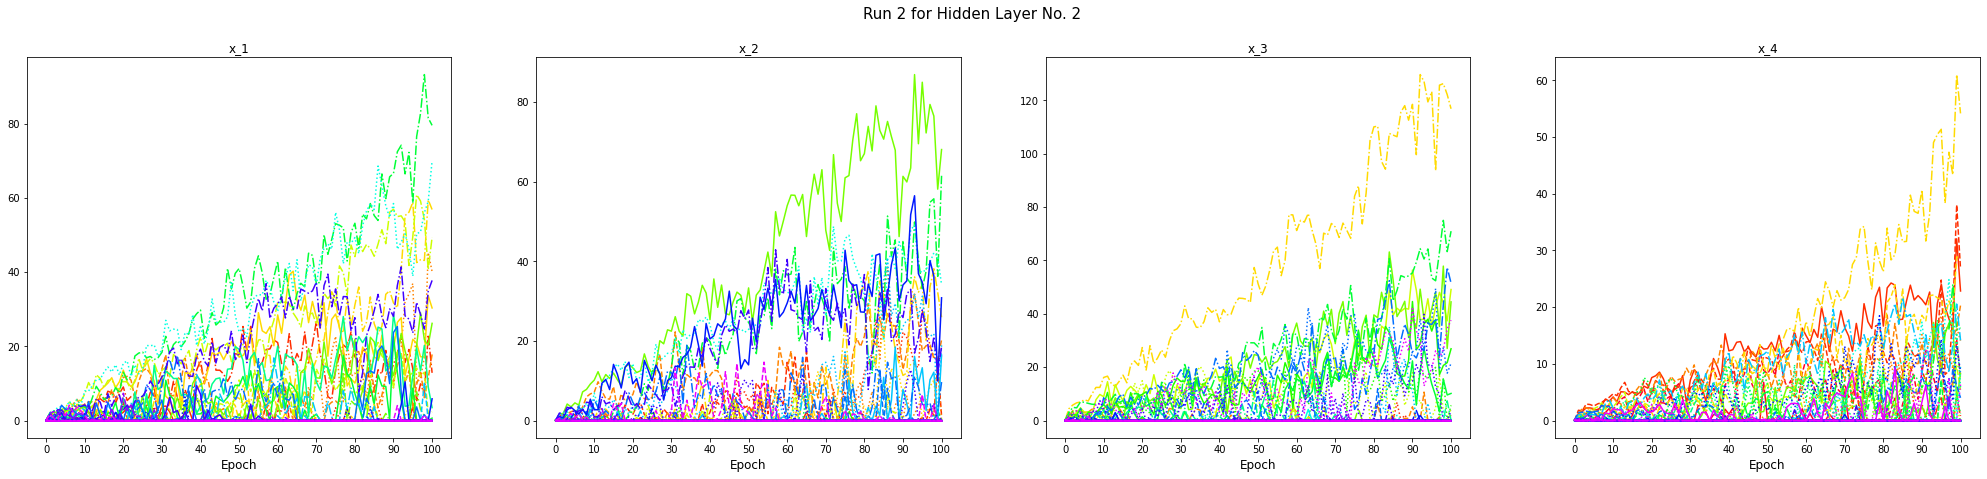

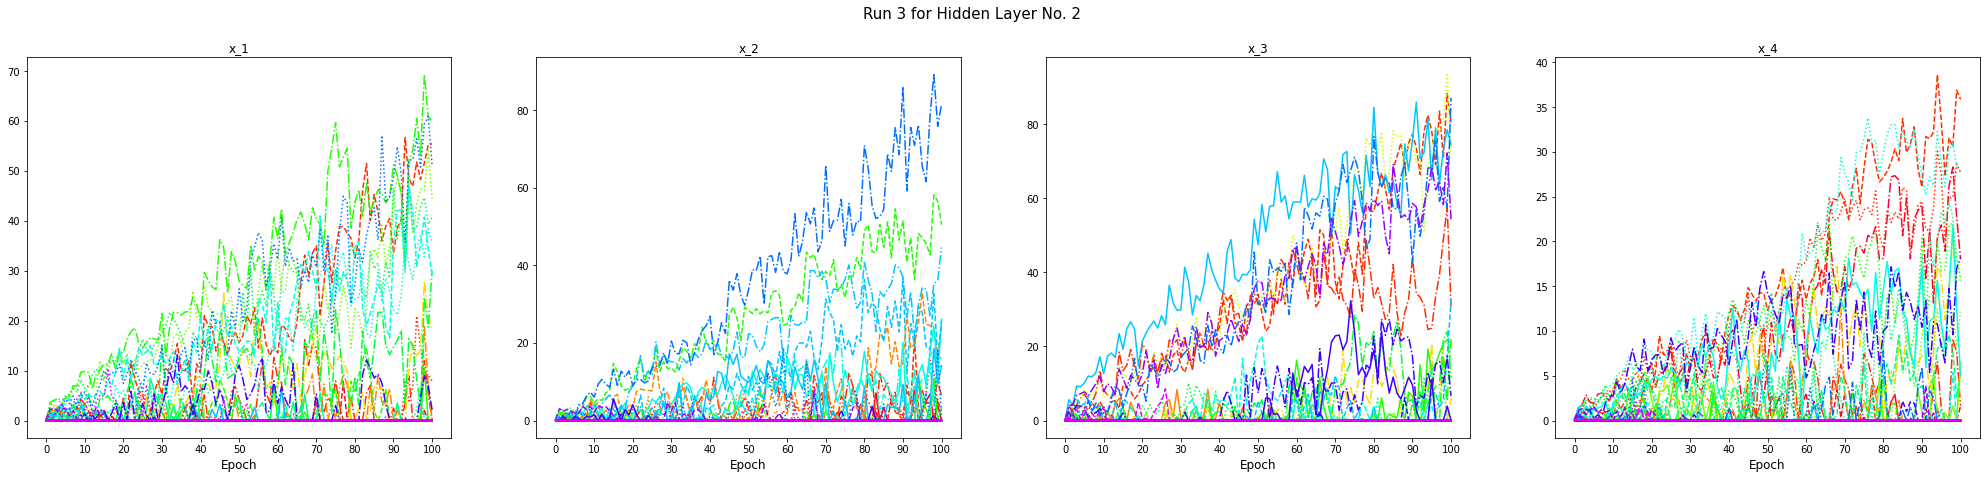

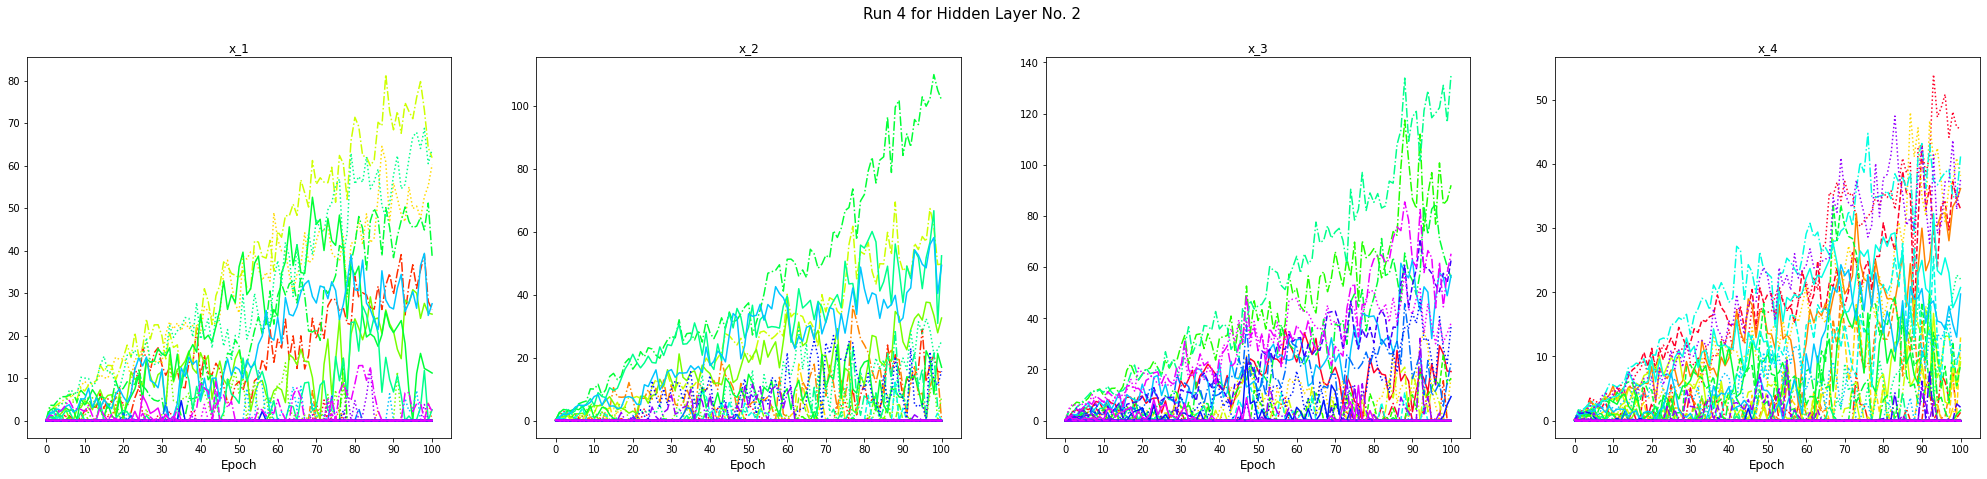

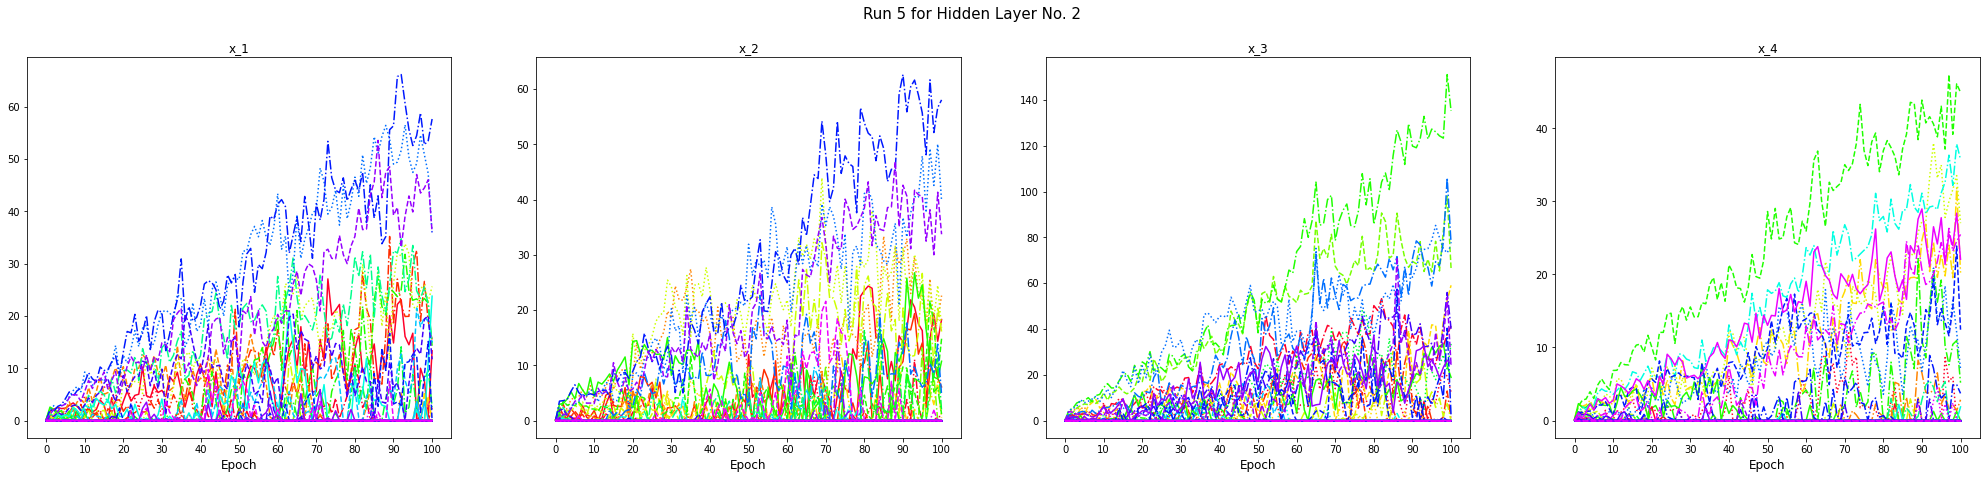

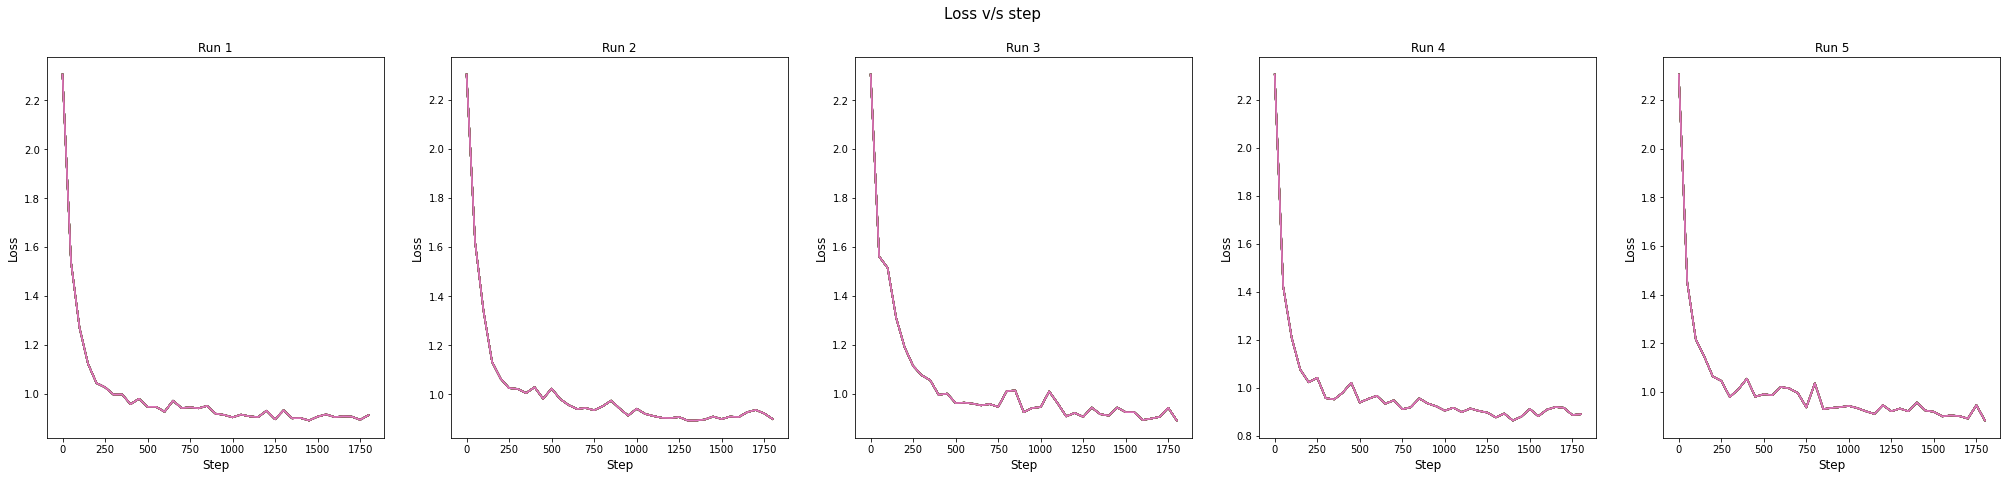

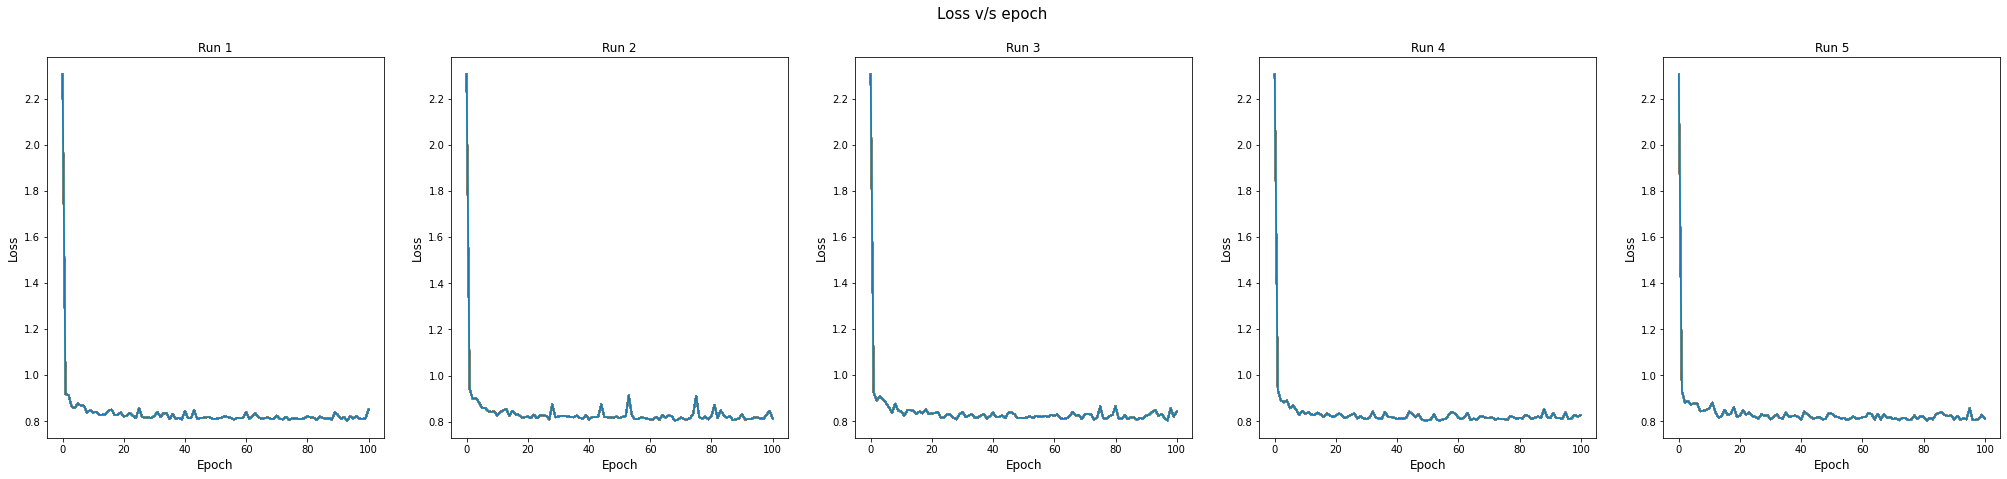

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [326]:
kernel_5_runs = build_kernels(hidden_layer_outs_5_runs)
for kernel_name in ['K2', 'K3','K']:
  plot_kernel_values_stepwise(kernel_name,kernel_5_runs, x_idxs_pair )
  plot_kernel_values_epochwise(kernel_name,kernel_5_runs, x_idxs_pair )

plot_stepwise_activations(hidden_layer_no =2, hidden_layer_outs_5_runs = hidden_layer_outs_5_runs)
plot_epochwise_activations(hidden_layer_no = 2, hidden_layer_outs_5_runs = hidden_layer_outs_5_runs)
plot_stepwise_loss(state_info_5_runs)
plot_epochwise_loss(state_info_5_runs)
plot_kernels(hidden_layer_outs_5_runs, state_info_5_runs,for_all_inputs = True, save_fig = True, show_fig = False)

#Saving results of each protocol
if save_result:
  file_name = f'{protocol}_5_32_MNIST_all_epochs_figs'
  save_results(file_name)

#Download all protocols result
if save_result:
  download_results()

In [ ]:
#Slider for visulalizing Y_true v/s Y_predicted
# preds = [v for x in predictions_5_runs[0] for v in x]
# plot_y_prediction(Y_sorted, preds)

In [ ]:
# #Store in pickle file
# temp_dict = {'hidden_layer_outs':hidden_layer_outs_5_runs, 'state_info':state_info_5_runs}
# info = state_info_5_runs[0][0][0]
# fname = f'{info['model_protocol_type']}_{info['n_hidden_layers']}_{info['n_neurons']}_pkl.pkl'
# with open(fname, "wb") as fp:   
#   pickle.dump(temp_dict, fp)


# os.system(f"zip -R {fname}.zip '*.pkl'")
# # !zip -r /content/DGN_DLGN_SF_5_32_all_epochs_pkl.zip /content/DGN_DLGN_SF_5_32_all_epochs_pkl
# files.download(f"{fname}.zip")

In [ ]:
# # !unzip /content/MLP_5_32_all_epochs_pkl.zip 
# with open("/content/content/MLP_5_32_all_epochs_pkl", "rb") as fp:  
#   b = pickle.load(fp)
# kernel_5_runs = b['kernels']
# state_info_5_runs = b['state_info']
# intermediate_outs_5_runs = b['hidden_layer_outs']

----------------------------------------------------------- Commented Old Codes -----------------------------------------------------------

In [ ]:
'''
[ 4629  1771 50630 50628 43602 51228  5368 30384  4962 15825 30044 48554
 32609 16326 45905 23372  2539  1386 39029 40320  1000 32574 48780 38177
 39155 15288 36412   283 10254 54404  7409  2084   119 55785 18278 10323
 57827 37220 24069 51629 33302 25325 43727 38055   489 17871 31476 40241
 33640 28904]
[46518 11637 53341 18546 51882 52868  5477  2907 21554 39444 45197 19742
 23554  6356 50838 56291 33577 46936 53531 11901 33440 17662 14293 23885
 59530 30117 36687 27967  3532  8873 57192 37155  4772 44705 26429 41524
 25940 24288 39622 13725 49035 37635 56491 45182 53001 34033 55338  3120
 46254 11793]
[20028 57933  8960 13922 41489 37734 53237   917 16309 10988 55589 37084
  8993 23171 19028 28832 39228 13774 47839 30975 30346 26794 39467 53837
 48624 43153 34155  8598  8460 57966 55528 48946 55381  1715  2418  3965
 43851  5624 52456 45505  3989 14063 21219 26164 50478 55001 16142 32485
 25700 29911]
[ 6118   495 51837 42120 49529 22234 56297 46525 25377 24356 37729 21325
 15872  6539  2286 58878 24042 38894 18588 31249 20356 25291 18380  4001
 46971 41629 44385 37913 51260 51776  6719   629  7625  4864 18044 58412
  9730 29023 38086 34427 28174 52939  3670 29225 59652 30417 16074 30489
 56721 15226]
[11008 58650 10560 28253 52522 19033 19032 57443 55552 43481 55004  4781
 39239 35624 13775 21590  3350  4768 39894  3903  7863 52988 23538 23103
 55024 54819 31458 16802 33165 29941 16338 44523 35904 44213 18846 57537
 11471 34389 40519  7327  3990 58225 29814 46052 55654 42346 35926 34465
 35141 47680]
[49048 19839 30390 36480 18416 24630 41533 42889 32501 18234 59822  6997
 52364 57345 49820 52540 51254 59216 22101 47854 19706 47940  5456 13863
 32570 42447 12484  7232  5292 41521   376 25295 34841   836 44819 55455
 47320 26290 46774 25508    11 41693  4004 10904 54400 25407 29029 24887
 57837 23183]
[17626 46003 35099 47006 30950 19293 11132 47415 28883 26347 11871 55456
 31606 48823 23421 49043 40491  7008 28934 19118 21025 16746 15051  9929
  9120  6789 16957 33751 58724  7504 34698 36637 33692 48380  2320 59591
 42027 51481 47864 43225 53081 16736 37966 34621 44742 37724 21003 19451
 59866 43141]
[52879 17703 24705  6221 59124  9992 54426 28723 54494  4217 34981 20370
 28117  3899 34472 38243 30952 55431 54207 45533  7961 13255 14455 43277
 27292 23621 10427 14076   968 11235  8828  6956 58977 42057 17443 58524
 16771 42016 45530 36691 35539 35321 37971 49553 18498 15098 50742 21437
 26560  9768]
[35428 43372 22849 27508  7026 33018 59542 56613 16937 50413  6006 37030
 53420   386 32573 20690 51412 49963 10738 58849 34820  8732 55761 59097
  9008 38267 32166 51513 19557 58643 21694 25796 50346 20725  5394 57244
 46793  6129 56284 44944 47030 16158 30067 12455 24110 54846 40453 58679
 55929 32175]
[46655 30085 11900 33199 22782 43596 51654 37115 50029  8899  2997 18731
  3904 50558 28168 15222 49734 37400 45944 58796 33891 10799 11366  3598
 11499 11388 21724 48580 52184 43888 55849 23732 42773 26877 16006 39932
 55454  3316 37306 35741 53280  7053 34616  9394 28750 33701  9969 45787
 21592 41953]

'''

In [ ]:
# #activation for epoch wise for MLP
# def plot_epochwise_activations():
#   if state_info_5_runs[0][0][0]['model_protocol_type'] != 'DGN':
#     temp = []
#     y_label = 'ReLU(x)' if state_info_5_runs[0][0][0]['model_protocol_type'] == 'MLP' else 'ReLU(x)*G(x)'
#     for i in range(5):
#       intermediate_outs = np.array(intermediate_outs_5_runs[i])
#       n_steps = [0,15, 30, 45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
#             56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
#             69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
#             82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
#             95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
#           108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
#           121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
#           134, 135, 136, 137, 138, 139, 140, 141, 142]
#       plotx1 = intermediate_outs[n_steps,0]
#       plotx2 = intermediate_outs[n_steps,1]
#       plotx3 = intermediate_outs[n_steps,2]
#       plotx4 = intermediate_outs[n_steps,3]
#       fig = plt.figure(figsize=(30,10))

    
#       plt.subplot(2, 2, 1)
#       plt.suptitle('Hidden Layer 2, Run = '+ str(i+1))
#       plt.plot(plotx1)
#       plt.title('x1')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
    

#       plt.subplot(2, 2, 2)
#       plt.plot(plotx2)
#       plt.title('x2')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 3)
#       plt.plot(plotx3)
#       plt.title('x3')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 4)
#       plt.plot(plotx4)
#       plt.title('x4')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)

#       plt.savefig(f'Run_{i+1}_epoch.png')
#       # plt.plot(plotx1, ax = axes[0])
#       # plt.title('x1')
#       # plt.plot(plotx2, ax = axes[1])
#       # plt.title('x2')
#       # plt.plot(plotx3, ax = axes[2])
#       # plt.title('x3')
#       # plt.plot(plotx4, ax = axes[3])
#       # plt.title('x4')
#     # intermediate_outs = temp
#     plt.show()
#   #activation for epoch wise for DGN
#   else:
#     temp = []
#     x = np.concatenate((np.arange(31), np.arange(31,250,5)))
#     for i in range(5):
#     #   if i ==0:
#     #     temp = np.concatenate(all_intermediate_outs[i], axis = 0)
#     #   else:
#     #     temp += np.concatenate(all_intermediate_outs[i], axis = 0)
#     # temp /= 5
#       # intermediate_outs = np.concatenate(all_intermediate_outs[i], axis = 0)
#       intermediate_outs = np.array(intermediate_outs_5_runs[i])
#       n_steps = [0,15, 30, 45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
#             56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
#             69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
#             82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
#             95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
#           108, 109, 110, 111, 112, 113, 114, 115, 116]
#       plotx1 = intermediate_outs[n_steps,0]
#       plotx2 = intermediate_outs[n_steps,1]
#       plotx3 = intermediate_outs[n_steps,2]
#       plotx4 = intermediate_outs[n_steps,3]
#       fig = plt.figure(figsize=(30,10))

#       y_label = 'ReLU(x)*G(x)'

#       plt.subplot(2, 2, 1)
#       plt.suptitle('Hidden Layer 2, Run = '+ str(i+1))
#       plt.plot(x,plotx1)
#       plt.title('x1')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
    

#       plt.subplot(2, 2, 2)
#       plt.plot(x, plotx2)
#       plt.title('x2')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 3)
#       plt.plot(x, plotx3)
#       plt.title('x3')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 4)
#       plt.plot(x, plotx4)
#       plt.title('x4')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)

#       plt.savefig(f'Run_{i+1}_epoch.png')
#       # plt.plot(plotx1, ax = axes[0])
#       # plt.title('x1')
#       # plt.plot(plotx2, ax = axes[1])
#       # plt.title('x2')
#       # plt.plot(plotx3, ax = axes[2])
#       # plt.title('x3')
#       # plt.plot(plotx4, ax = axes[3])
#       # plt.title('x4')
#     # intermediate_outs = temp
#     plt.show()

In [ ]:
# #activation for epoch wise for MLP
# def plot_epochwise_activations():
#   if state_info_5_runs[0][0][0]['model_protocol_type'] != 'DGN':
#     temp = []
#     y_label = 'ReLU(x)' if state_info_5_runs[0][0][0]['model_protocol_type'] == 'MLP' else 'ReLU(x)*G(x)'
#     for i in range(5):
#       intermediate_outs = np.array(intermediate_outs_5_runs[i])
#       n_steps = [0,15, 30, 45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
#             56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
#             69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
#             82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
#             95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
#           108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
#           121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
#           134, 135, 136, 137, 138, 139, 140, 141, 142]
#       plotx1 = intermediate_outs[n_steps,0]
#       plotx2 = intermediate_outs[n_steps,1]
#       plotx3 = intermediate_outs[n_steps,2]
#       plotx4 = intermediate_outs[n_steps,3]
#       fig = plt.figure(figsize=(30,10))

    
#       plt.subplot(2, 2, 1)
#       plt.suptitle('Hidden Layer 2, Run = '+ str(i+1))
#       plt.plot(plotx1)
#       plt.title('x1')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
    

#       plt.subplot(2, 2, 2)
#       plt.plot(plotx2)
#       plt.title('x2')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 3)
#       plt.plot(plotx3)
#       plt.title('x3')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 4)
#       plt.plot(plotx4)
#       plt.title('x4')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)

#       plt.savefig(f'Run_{i+1}_epoch.png')
#       # plt.plot(plotx1, ax = axes[0])
#       # plt.title('x1')
#       # plt.plot(plotx2, ax = axes[1])
#       # plt.title('x2')
#       # plt.plot(plotx3, ax = axes[2])
#       # plt.title('x3')
#       # plt.plot(plotx4, ax = axes[3])
#       # plt.title('x4')
#     # intermediate_outs = temp
#     plt.show()
#   #activation for epoch wise for DGN
#   else:
#     temp = []
#     x = np.concatenate((np.arange(31), np.arange(31,250,5)))
#     for i in range(5):
#     #   if i ==0:
#     #     temp = np.concatenate(all_intermediate_outs[i], axis = 0)
#     #   else:
#     #     temp += np.concatenate(all_intermediate_outs[i], axis = 0)
#     # temp /= 5
#       # intermediate_outs = np.concatenate(all_intermediate_outs[i], axis = 0)
#       intermediate_outs = np.array(intermediate_outs_5_runs[i])
#       n_steps = [0,15, 30, 45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
#             56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
#             69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
#             82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
#             95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
#           108, 109, 110, 111, 112, 113, 114, 115, 116]
#       plotx1 = intermediate_outs[n_steps,0]
#       plotx2 = intermediate_outs[n_steps,1]
#       plotx3 = intermediate_outs[n_steps,2]
#       plotx4 = intermediate_outs[n_steps,3]
#       fig = plt.figure(figsize=(30,10))

#       y_label = 'ReLU(x)*G(x)'

#       plt.subplot(2, 2, 1)
#       plt.suptitle('Hidden Layer 2, Run = '+ str(i+1))
#       plt.plot(x,plotx1)
#       plt.title('x1')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
    

#       plt.subplot(2, 2, 2)
#       plt.plot(x, plotx2)
#       plt.title('x2')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 3)
#       plt.plot(x, plotx3)
#       plt.title('x3')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 4)
#       plt.plot(x, plotx4)
#       plt.title('x4')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)

#       plt.savefig(f'Run_{i+1}_epoch.png')
#       # plt.plot(plotx1, ax = axes[0])
#       # plt.title('x1')
#       # plt.plot(plotx2, ax = axes[1])
#       # plt.title('x2')
#       # plt.plot(plotx3, ax = axes[2])
#       # plt.title('x3')
#       # plt.plot(plotx4, ax = axes[3])
#       # plt.title('x4')
#     # intermediate_outs = temp
#     plt.show()

In [ ]:
# # For epoch wise loss analysis
# def plot_epochwise_loss():
#   values = []
#   for run in range(len(kernel_5_runs)):
#     for epoch in range(len(kernel_5_runs[run])):
#         loss = state_info_5_runs[run][epoch][-1]['loss']
#         values.append(loss)
        
#         # print(run, epoch)
#         # plot_heatmap(kernel_5_runs[run][epoch][step], state_info_5_runs[run][epoch][step])
      
#   values = np.array(values)

#   #For loss v/s epoch for MLP
#   if state_info_5_runs[0][0][0]['model_protocol_type'] != 'DGN':
#     f, axes = plt.subplots(1, 5,figsize = (5*10,10))
#     for run in range(5):
#       plt.suptitle('Loss v/s epoch',ha = 'center', fontsize = 30)
#       for i in range(len(values)):
#         one_run_len = int(values.shape[0]/5)
#         start = run*one_run_len
#         axes[run].plot(values[start:start+one_run_len])
#         axes[run].set_xlabel(f'Run {run+1}', fontsize = 20)
#         axes[run].set_xticks(np.arange(0,one_run_len, 5.0))

#     plt.savefig('loss_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
#     plt.show()

#   # For loss v/s epoch for DGN 
#   else:
#     f, axes = plt.subplots(1, 5,figsize = (5*10,10))
#     x = np.concatenate((np.arange(31), np.arange(31,250,5)))  
#     for run in range(5):
#       plt.suptitle('Loss v/s epoch',ha = 'center', fontsize = 30)
#       for i in range(len(values)):
#         one_run_len = int(values.shape[0]/5)
#         start = run*one_run_len
#         axes[run].plot(x, values[start:start+one_run_len])
#         axes[run].set_xticks(np.arange(min(x), max(x)+1, 10.0))
#         axes[run].set_xlabel(f'Run {run+1}', fontsize = 20)
#     plt.savefig('loss_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
#     plt.show()

In [ ]:

'''
  # Kernel value graphs epoch wise for MLP
  if state_info_5_runs[0][0][0]['model_protocol_type'] != 'DGN':
    labels = ['x1x1', 'x2x2', 'x3x3', 'x4x4', 'x1x2', 'x3x4']
    f, axes = plt.subplots(5, 1,figsize = (20,7*5))
    for run in range(5):
      # plt.figure(figsize = (10,10))
      plt.suptitle(f'{kernel_name}_epoch',ha = 'center', fontsize = 30)
      for i in range(len(values)):
        one_run_len = int(values.shape[1]/5)
        start = run*one_run_len
        axes[run].plot(values[i][start:start+one_run_len], label=labels[i])
        axes[run].set_xlabel(f'Run {run+1}', fontsize = 20)
        axes[run].legend(loc='best')

    plt.savefig(f'{kernel_name}_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
    plt.show()

  #Kernel value graphs epoch wise for DGN since it is plotted in interval of 5 after 30 epochs
  else:
    labels = ['x1x1', 'x2x2', 'x3x3', 'x4x4', 'x1x2', 'x3x4']
    f, axes = plt.subplots(5, 1,figsize = (20,7*5))
    x = np.concatenate((np.arange(31), np.arange(31,250,5)))  
    for run in range(5):
      plt.suptitle(f'{kernel_name}_epoch',ha = 'center', fontsize = 30)
      for i in range(len(values)):
        one_run_len = int(values.shape[1]/5)
        start = run*one_run_len
        axes[run].plot(x, values[i][start:start+one_run_len], label=labels[i])
        axes[run].set_xticks(np.arange(min(x), max(x)+1, 10.0))
        axes[run].set_xlabel(f'Run {run+1}', fontsize = 20)
        axes[run].legend(loc='best')

    plt.savefig(f'{kernel_name}_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
    plt.show()
'''

In [ ]:
# import numpy as np 
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

# #from  https://stackoverflow.com/questions/47230817/plotly-notebook-mode-with-google-colaboratory
# def configure_plotly_browser_state():
#   import IPython
#   display(IPython.core.display.HTML('''
#         <script src="/static/components/requirejs/require.js"></script>
#         <script>
#           requirejs.config({
#             paths: {
#               base: '/static/base',
#               plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext', 
#             },
#           });
#         </script>
#         '''))


# init_notebook_mode(connected=True)

# #from plotly sliders
# data = [dict(
#         visible = False,
#         line=dict(color='#00CED1', width=2),
#         name = '𝜈 = '+str(step),
#         x = np.arange(0,500,1),
#         y = d.to('cpu').flatten(),
#         #  y =Y_sorted.flatten()
#        ) for d in predictions_run]
# data[10]['visible'] = True

# data2 = [dict(
#         visible = False,
#         line=dict(color='#00CED1', width=2),
#         name = '𝜈 = '+str(step),
#         x = np.arange(0,500,1),
#         y = Y_sorted.flatten(),
#        ) for d in predictions_run]
# data[10]['visible'] = True

# #configure added to visualize in colab
# configure_plotly_browser_state()

# steps = []
# for i in range(len(data)):
#     step = dict(
#         method = 'restyle',  
#         args = ['visible', [False] * len(data)],
#     )
#     step['args'][1][i] = True # Toggle i'th trace to "visible"
#     steps.append(step)

# sliders = [dict(
#     active = 10,
#     currentvalue = {"prefix": "Frequency: "},
#     pad = {"t": 50},
#     steps = steps
# )]

# layout = dict(sliders=sliders)

# fig = dict(data=data, layout=layout)

# fig2 = dict(data=data2, layout=layout)
# configure_plotly_browser_state()


# #removed py. from original plotly code 
# iplot(fig, filename='Sine Wave Slider')
# iplot(fig2, filename='Sine Wave Slider')


In [ ]:
# output = pd.DataFrame(state_info)
# sub_out = pd.DataFrame(list(output[4]))

# sub_out = sub_out.fillna(value='Null')
# cols = sub_out.ne('Null').cumsum(axis=1).idxmax(axis=1)
# K_temp = sub_out.lookup(sub_out.index, cols)

# cols = list(cols)

# for i, row in sub_out.iterrows():
#   sub_out.at[i,cols[i]] = 'Null'
# sub_out.insert(0, 'K', K_temp)

# final_sub_out = sub_out
# final_output = pd.concat([output, final_sub_out], axis = 1, ignore_index=True)


# final_output = final_output.drop([4, final_output.shape[1]-1], 1)
# final_output

#final_output = final_output.drop([4, -1], 1)
# final_output = final_output.set_axis(['protocol', 'n_h_l', 'n_n','Run', 'Status', 'K', 'K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8'], axis=1, inplace=False)
# final_output = final_output.set_axis(['protocol', 'n_h_l', 'n_n','Run', 'Status', 'K', 'K1', 'K2', 'K3', 'K4', 'K5'], axis=1, inplace=False)

# final_output.to_csv('final_output.csv')
# files.download("final_output.csv")
# dF1 = pd.read_csv("final_output1.csv")
# dF2 = pd.read_csv("final_output2.csv")
# dF3 = pd.read_csv("final_output3.csv")
# dF4 = pd.read_csv("final_output4.csv")
# dF5 = pd.read_csv("final_output5.csv")
# dF6 = pd.read_csv("final_output6.csv")
# sin10_all_out = pd.concat([dF6, dF1,dF3, dF4,dF5, dF2], axis=0).drop(['Unnamed: 0'], axis = 1)
# dF7 = pd.read_csv("final_output7.csv")
# dF8 = pd.read_csv("final_output8.csv")
# sin4_all_out = pd.concat([dF7, dF8], axis=0).drop(['Unnamed: 0'], axis = 1)
# sin10_all_out.to_csv('sin10_all_output.csv')
# sin4_all_out.to_csv('sin4_all_output.csv')

In [ ]:
# def  get_hyperplanes_params(model, for_layers):
#   layer_weights = []
#   layer_slopes = []
#   layer_intercepts = []
#   for i in range(for_layers):
#     layer_weight = model.layers[i].weight.detach().to("cpu")
#     layer_slope = -(layer_weight[:,0]/layer_weight[:,1])
#     layer_intercept = [0]*32#model.layers[i].bias.detach().to("cpu")

#     layer_weights.append(layer_weight)
#     layer_slopes.append(layer_slope)
#     layer_intercepts.append(layer_intercept)
#   return layer_slopes, layer_intercepts


# def plot_hyperplanes(model, train_status):
  
#   for_layers = len(model.layers)-1
#   layer_slopes, layer_intercepts = get_hyperplanes_params(model, for_layers)
  
  
#   x_axis = np.linspace(start = -2, stop = 2)
#   for i in range(for_layers):
#     plt.figure(figsize = (10,10))
#     #fig, ax = plt.subplots(figsize = (10,10))
#     ax = sns.scatterplot(X_sorted[:,0], X_sorted[:,1], c = prediction.to("cpu"))
#     ax.set_xlim((-2,2))
#     ax.set_ylim((-2,2))
#     for j in range(32):
#       y_axis = layer_slopes[i][j]*x_axis + layer_intercepts[i][j]
#       #plt.plot(x_axis, y_axis)
#       sns.lineplot(x = x_axis, y = y_axis)
#     plt.title(train_status+" Layer_"+str(i+1))
#     plt.savefig(train_status+" Layer_"+str(i+1))
#     plt.show()

#     plot_hyperplanes(npf_model, model_protocol_type+" "+model_learning_status)